# Analysis of COVID-19 Vaccines in California
### By Alex Lee

### Introduction
In the past 2 years, COVID-19 has rapidly spread throughout the world and has changed many fundamental ways of living. It has also had a detrimental effect on life with almost 5 million deaths worldwide. In this project, I first analyze and observe the effect of vaccine distribution on COVID cases and deaths throughout the United States through geomapping. I then shift to just California data for further analysis on cases, deaths, and the effect of vaccination. This is done thorugh a series of visual plots as well as an OLS regression model with L2 regularization. In addition, I further analyze the effect of vaccine booster approval and provide recomendations and analysis for the demand associated following this new approval. Finally, I analyze differences in vaccination rates by county in California. I use hypothesis testing to statistically analyze differences in vaccination due to hesitance and metrics such as the Surgo Covid-19 Vaccine Coverage Index (CVAC).  

In [16]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Latex, Markdown

## Data

For this project, I obtained vaccination data and hesitancy data from the CDC. In addition, I obtained data on cases, deaths, and counties from datasets provided by the NY Times. 

#### CDC Datasets

In [17]:
statesVaccine = pd.read_csv("us_state_vaccinations.csv")

In [18]:
hesitance = pd.read_csv("Vaccine_Hesitancy_for_COVID-19__County_and_local_estimates.csv")

#### NY Times Datasets

In [19]:
states = pd.read_csv('States.csv')

In [20]:
country = pd.read_csv("Country.csv")


In [21]:
county = pd.read_csv('Counties.csv')


#### Datasets for Future Work

In [22]:
#worldProgress = pd.read_csv("World_Vaccination_Progress.csv")
#unicef = pd.read_csv("fusion_IMMUNISATION_UNICEF_1.0_all.csv")

## Data Cleaning

The states vaccine data has information for provinces and American territories, for this project, I will analyze just the 50 states on the mainlaind as well as the District of Columbia. In addition, to match the data in the vaccine and covid datasets, I will be taking data from the most recent overlap date, October 22, 2021. 

In [23]:
statesRecent = statesVaccine[statesVaccine['date'] == '2021-10-22'].reset_index(drop = True)
statesRecent.head()

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-10-22,Alabama,4742444.0,7045270.0,2644229.0,44.26,96.72,2170323.0,53.93,143.69,9615.0,9226.0,1882.0,0.673
1,2021-10-22,Alaska,849541.0,1128425.0,430458.0,52.16,116.13,381595.0,58.84,154.25,2334.0,3711.0,5073.0,0.753
2,2021-10-22,American Samoa,65441.0,70650.0,35202.0,55.30,117.51,30797.0,63.21,126.87,0.0,213.0,3825.0,0.926
3,2021-10-22,Arizona,8602398.0,10471530.0,4422905.0,52.61,118.19,3829511.0,60.76,143.87,24071.0,17041.0,2341.0,0.822
4,2021-10-22,Arkansas,3168727.0,4290340.0,1734334.0,47.52,105.00,1434030.0,57.47,142.17,7374.0,5899.0,1955.0,0.739


In [24]:
statesRecent['location'].replace({'New York State': 'New York'}, inplace = True)

In [25]:
statesRecent2 = states[states['date'] == '2021-10-22']
statesRecent2 = statesRecent2[['state', 'cases', 'deaths']].reset_index(drop = True)
statesRecent2.head()

,state,cases,deaths
0,Alabama,818652,15378
1,Alaska,132393,680
2,American Samoa,1,0
3,Arizona,1145196,20826
4,Arkansas,509559,8255


In [26]:
stateData = statesRecent2.merge(statesRecent, how = 'inner', left_on = 'state', right_on = 'location')

In [27]:
stateData = stateData.drop('location', axis = 1)

In [28]:
stateData.head()

,state,cases,deaths,date,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,Alabama,818652,15378,2021-10-22,4742444.0,7045270.0,2644229.0,44.26,96.72,2170323.0,53.93,143.69,9615.0,9226.0,1882.0,0.673
1,Alaska,132393,680,2021-10-22,849541.0,1128425.0,430458.0,52.16,116.13,381595.0,58.84,154.25,2334.0,3711.0,5073.0,0.753
2,American Samoa,1,0,2021-10-22,65441.0,70650.0,35202.0,55.30,117.51,30797.0,63.21,126.87,0.0,213.0,3825.0,0.926
3,Arizona,1145196,20826,2021-10-22,8602398.0,10471530.0,4422905.0,52.61,118.19,3829511.0,60.76,143.87,24071.0,17041.0,2341.0,0.822
4,Arkansas,509559,8255,2021-10-22,3168727.0,4290340.0,1734334.0,47.52,105.00,1434030.0,57.47,142.17,7374.0,5899.0,1955.0,0.739


In [29]:
stateData.drop([2, 12, 37, 42, 50], axis = 0, inplace = True)

In [30]:
stateData = stateData.reset_index().drop(['index'], axis = 1)

Converting the data set to a geopandas dataframe in order to make geographical plots. 

In [31]:
from geopandas import GeoSeries, GeoDataFrame
stateGeoCases = gpd.GeoDataFrame(stateData)

In [32]:
stateGeoCases.head()

,state,cases,deaths,date,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,Alabama,818652,15378,2021-10-22,4742444.0,7045270.0,2644229.0,44.26,96.72,2170323.0,53.93,143.69,9615.0,9226.0,1882.0,0.673
1,Alaska,132393,680,2021-10-22,849541.0,1128425.0,430458.0,52.16,116.13,381595.0,58.84,154.25,2334.0,3711.0,5073.0,0.753
2,Arizona,1145196,20826,2021-10-22,8602398.0,10471530.0,4422905.0,52.61,118.19,3829511.0,60.76,143.87,24071.0,17041.0,2341.0,0.822
3,Arkansas,509559,8255,2021-10-22,3168727.0,4290340.0,1734334.0,47.52,105.00,1434030.0,57.47,142.17,7374.0,5899.0,1955.0,0.739
4,California,4867059,71504,2021-10-22,52985233.0,61321935.0,29152953.0,60.68,134.10,23974163.0,73.78,155.20,116045.0,99011.0,2506.0,0.864


In [313]:
locs = gpd.read_file("cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

In [314]:
locs = locs[['NAME', 'geometry']]

In [315]:
locs = locs.merge(stateGeoCases, how = 'inner', left_on = 'NAME', right_on = 'state')
locs.drop('state', axis = 1, inplace = True)

For graphical organization purposes, Alaska and Hawaii will be ommitted from the main plots.

In [316]:
hawaii = locs.iloc[[39]]
alaska = locs.iloc[[26]]
locs.drop([26, 39], axis = 0, inplace = True)

## Visualizations and Data Exploration

The following plots reveal the levels of COVID cases, deaths, vaccination rates per 100 people, and daily vaccinations in all 50 states of the USA.

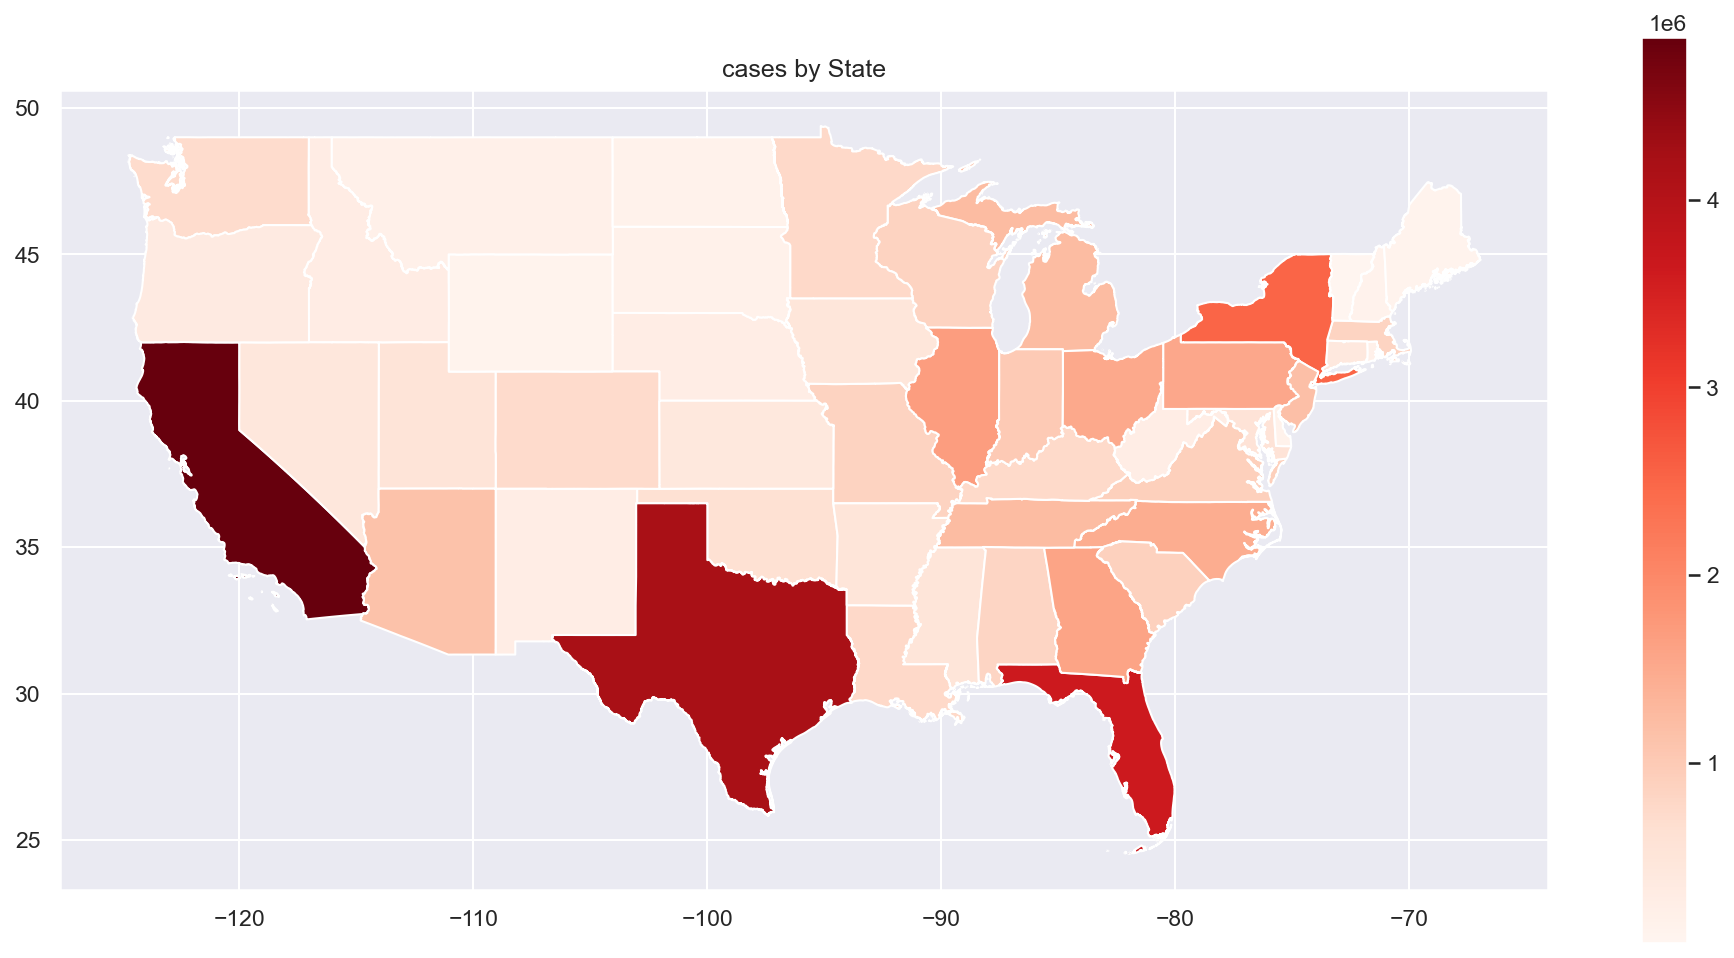

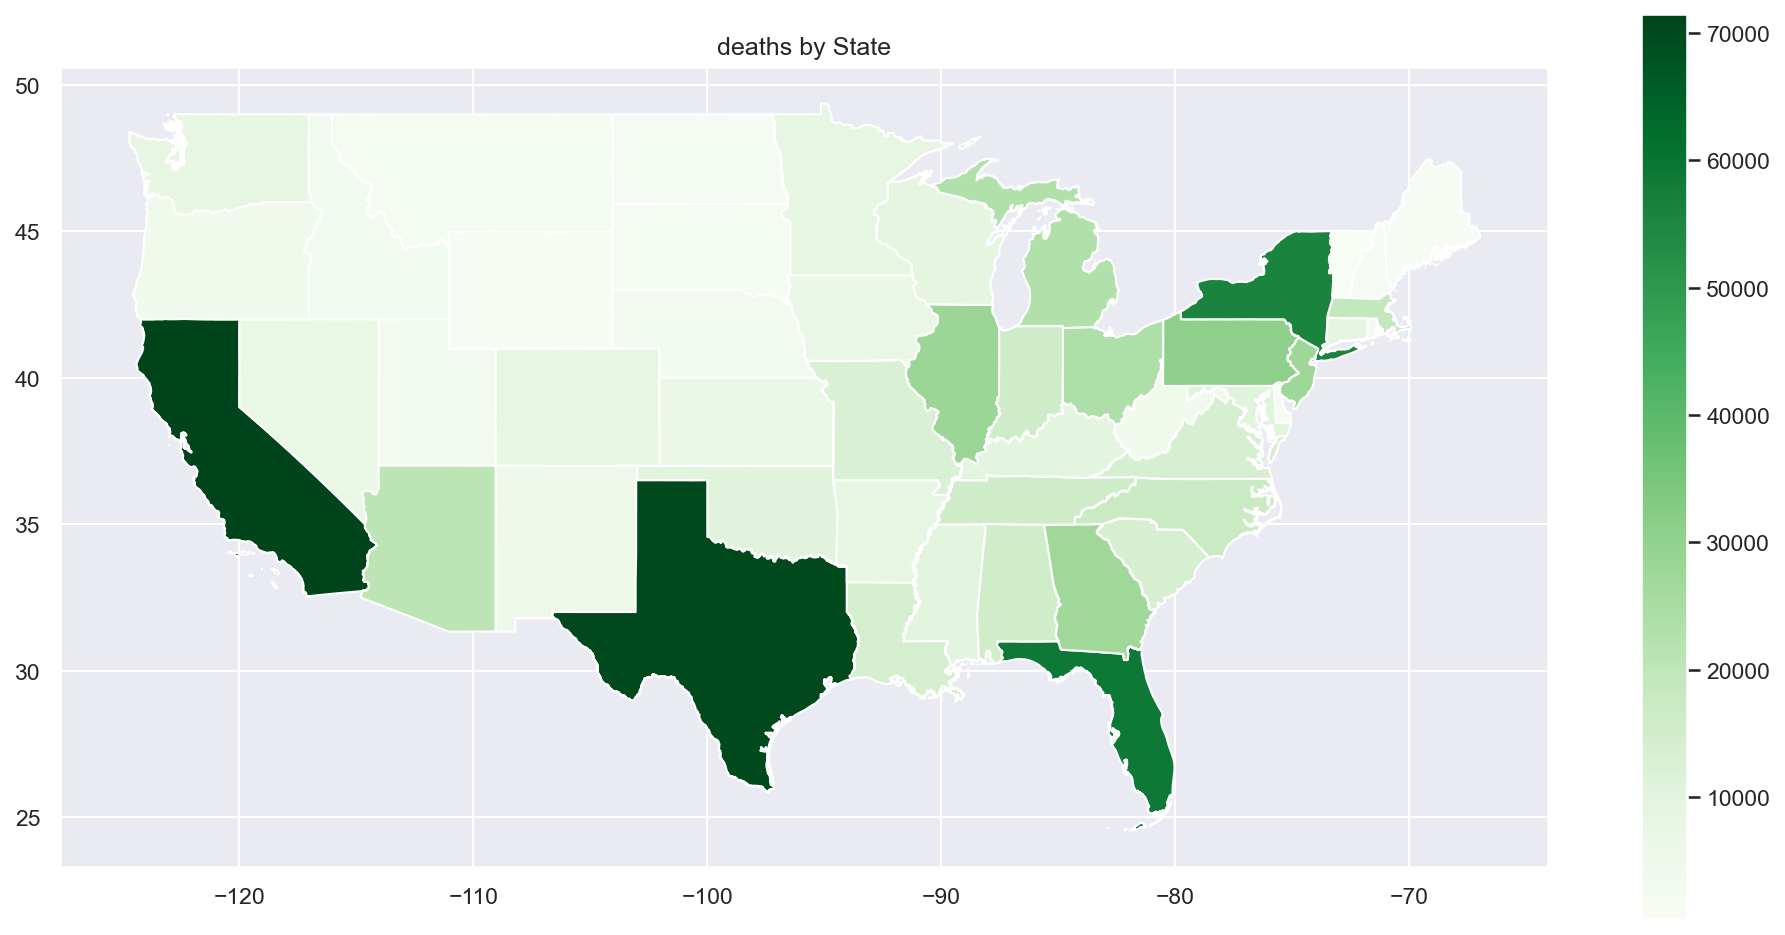

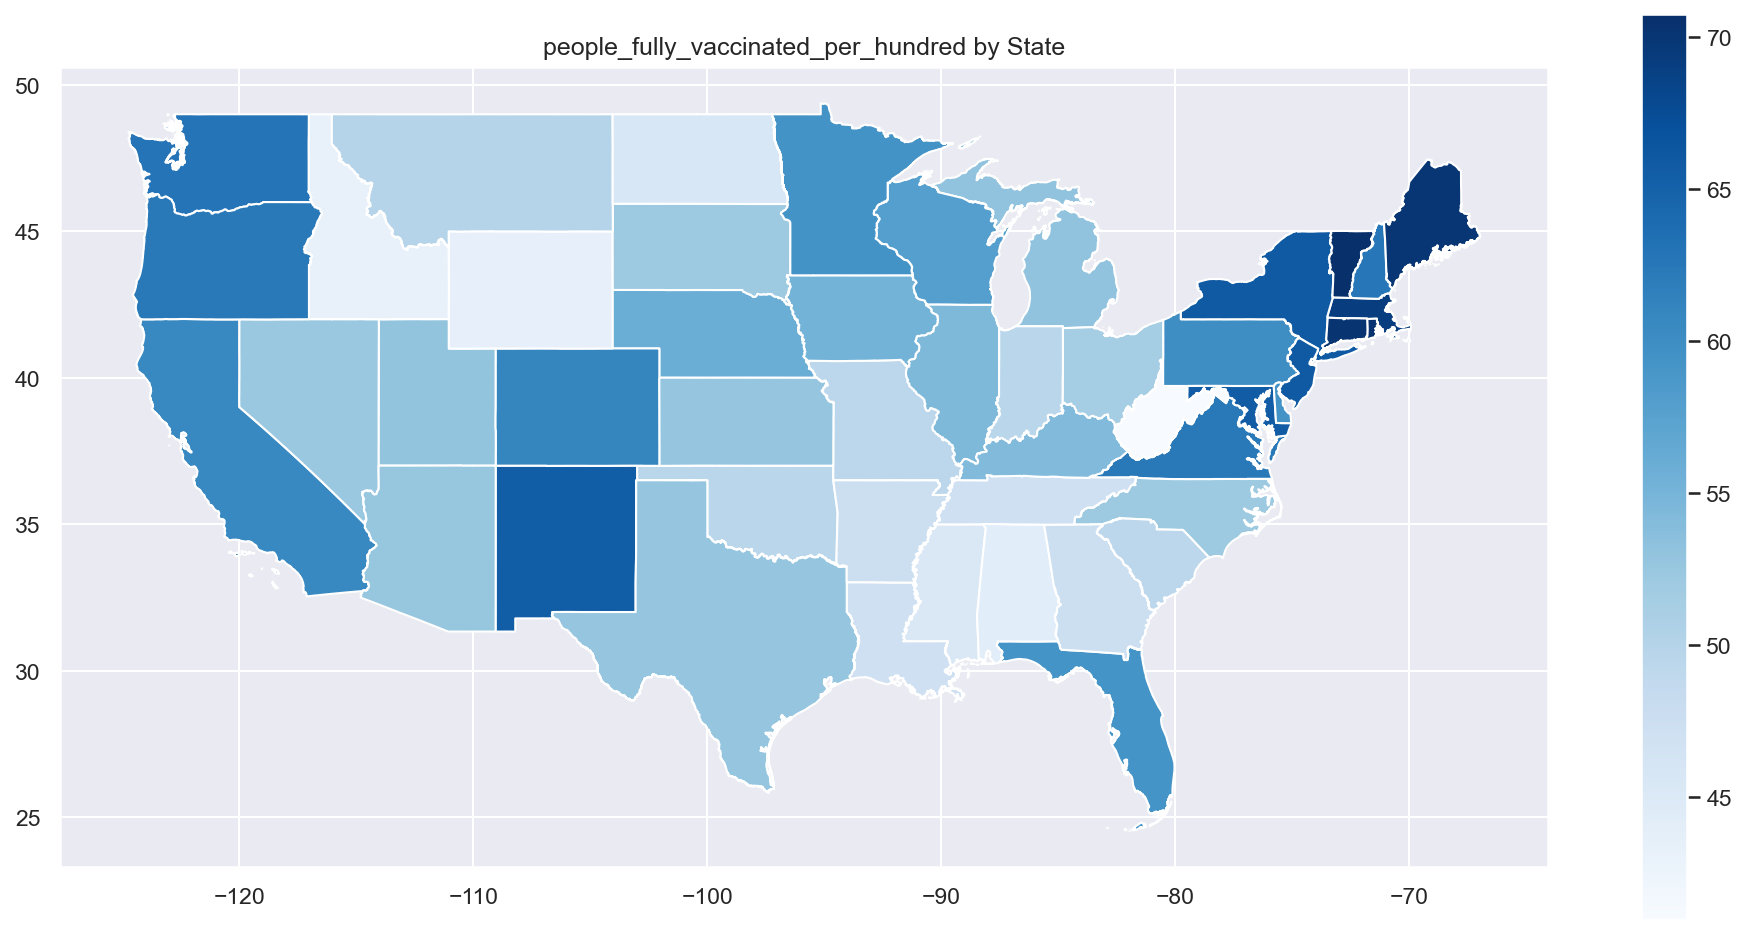

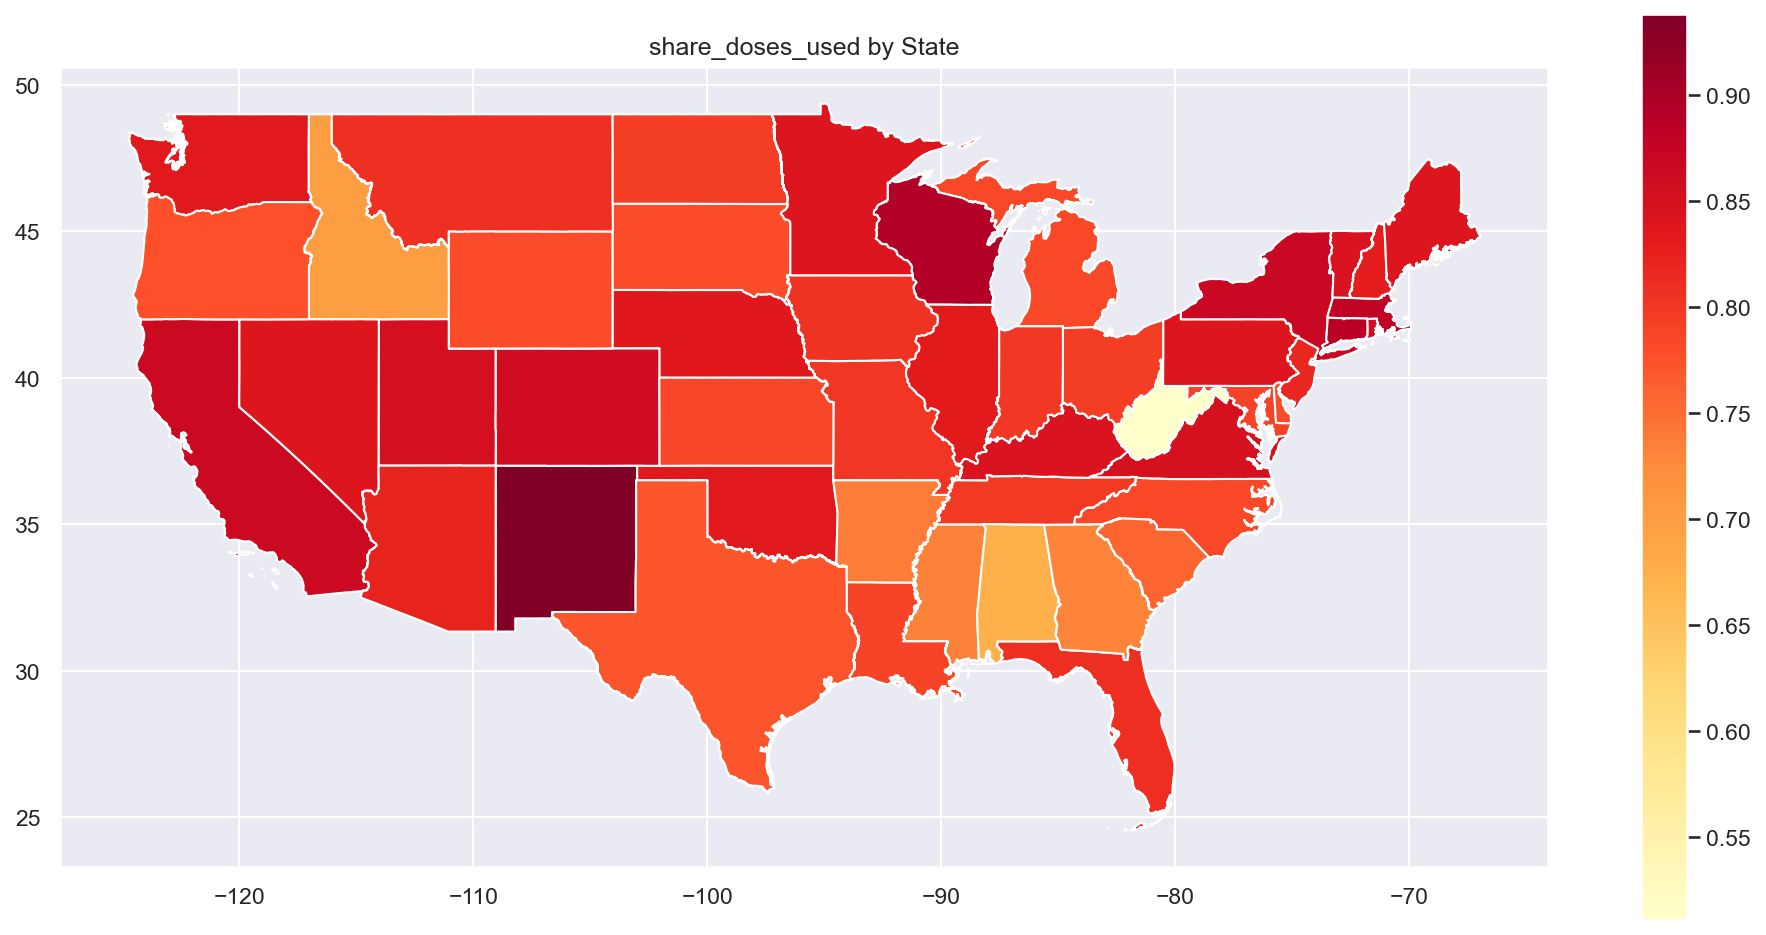

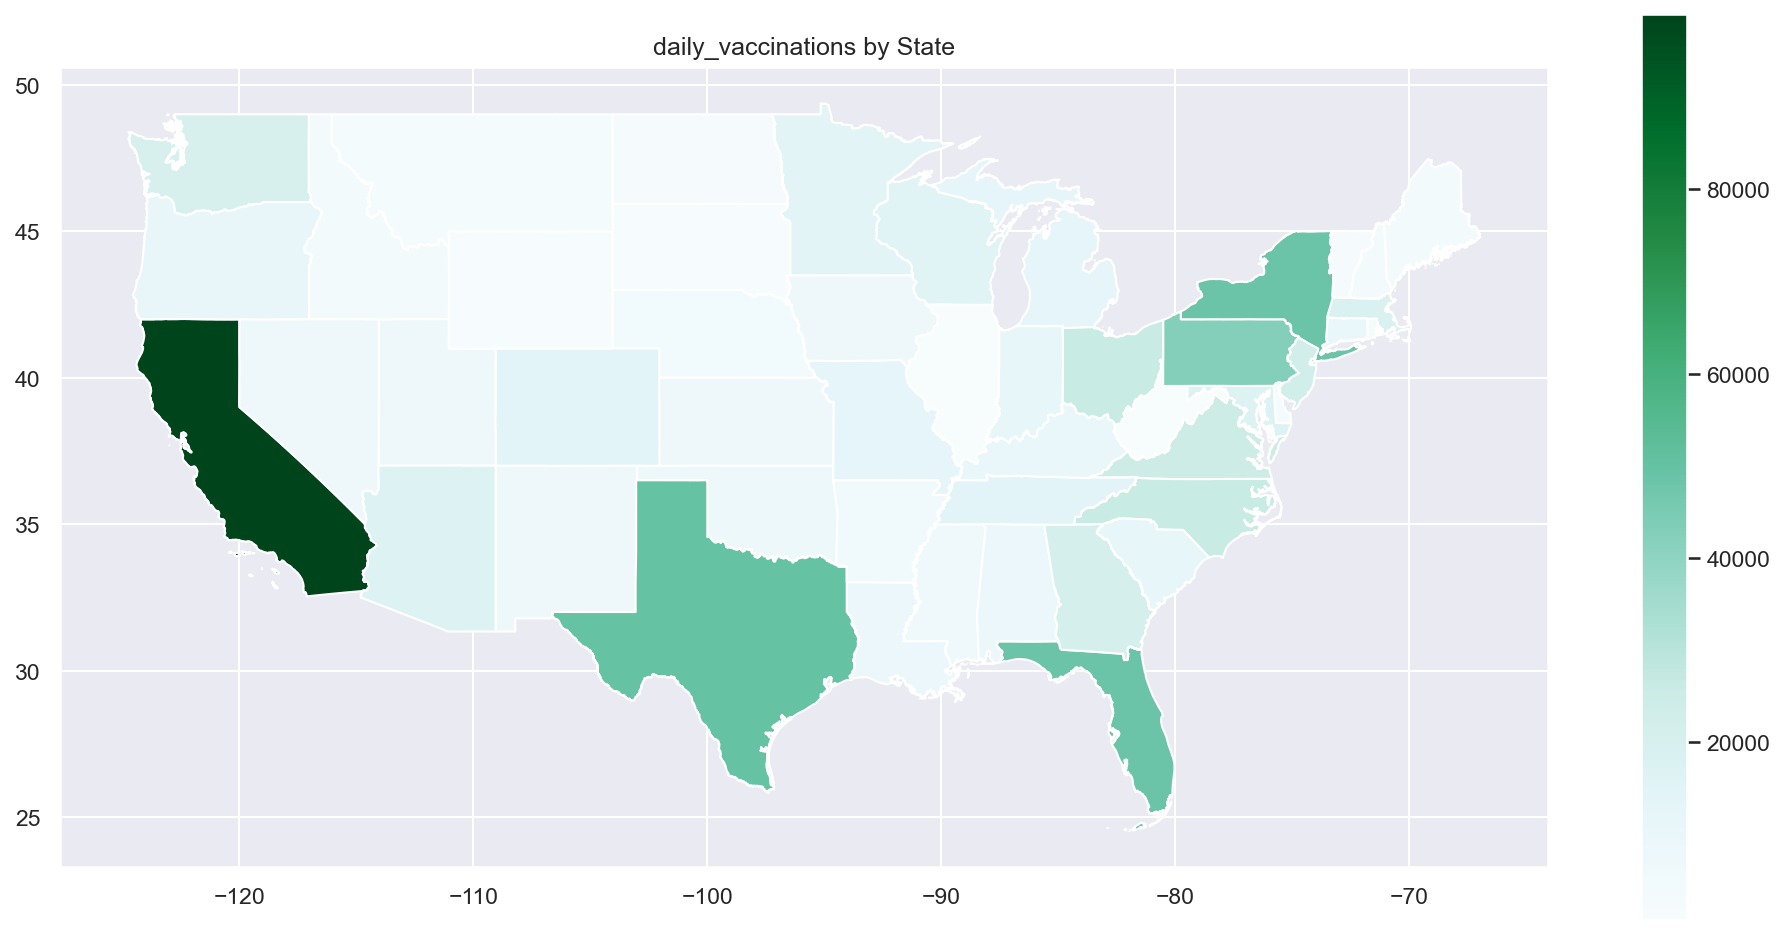

In [381]:
cols = locs[['cases', 'deaths', 'people_fully_vaccinated_per_hundred', 'share_doses_used', 'daily_vaccinations']]
colors = ['Reds', 'Greens', 'Blues', 'YlOrRd', 'BuGn']
index = 0
for col in cols.columns:
    fig, ax = plt.subplots(1, 1)
    locs.plot(column = col, cmap = colors[index], ax=ax, legend=True)
    index += 1
    plt.title(col + ' by State'); 

## California
To gain a better understanding of the dataset and to dive deeper into analysis of COVID-19 cases and vaccine distribution, I will analyze California. I am choosing California as it has a large population, a high number of covid cases, and a high vaccine distribution. 

In [318]:
ca_locs = locs[locs['NAME'] == 'California'].reset_index(drop = True)
caVaccineTime = statesVaccine[statesVaccine['location'] == 'California'].reset_index(drop = True)
caCovidTime = states[states['state'] == 'California'].reset_index(drop = True)

In [448]:
caCovidTime.head()

,date,state,fips,cases,deaths,Daily Deaths,Daily Cases
39,2020-03-04,California,6,55,1,1.0,10.0
44,2020-03-09,California,6,172,2,1.0,60.0
45,2020-03-10,California,6,179,3,1.0,7.0
46,2020-03-11,California,6,202,4,1.0,23.0
48,2020-03-13,California,6,320,5,1.0,68.0


In [447]:
caVaccineTime.head()

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
1,2021-01-13,California,891489.0,3435650.0,744545.0,0.34,2.26,133689.0,1.88,8.70,75188.0,75188.0,1903.0,0.259
3,2021-01-15,California,1072959.0,3548575.0,865387.0,0.52,2.72,204374.0,2.19,8.98,97666.0,85553.0,2165.0,0.302
8,2021-01-20,California,1532329.0,4169450.0,1255311.0,0.69,3.88,273276.0,3.18,10.55,71899.0,91549.0,2317.0,0.368
9,2021-01-21,California,1633875.0,4379500.0,1335886.0,0.74,4.14,293834.0,3.38,11.08,101546.0,94083.0,2381.0,0.373
10,2021-01-22,California,1803679.0,4714625.0,1477195.0,0.81,4.56,321839.0,3.74,11.93,169804.0,104389.0,2642.0,0.383


Because the dataset provided gives the total number of cases and deaths (as a cummulative number), I added two new columns to represent the daily cases and deaths. This will help to better analyze the effect of vaccine administration in California. 

In [321]:
caCovidTime['Daily Deaths'] = caCovidTime['deaths'].diff().fillna(0)
caCovidTime['Daily Cases'] = caCovidTime['cases'].diff().fillna(0)

Because of errors and occassional poor data collection, I ommitted some of the outliers for my analysis. 

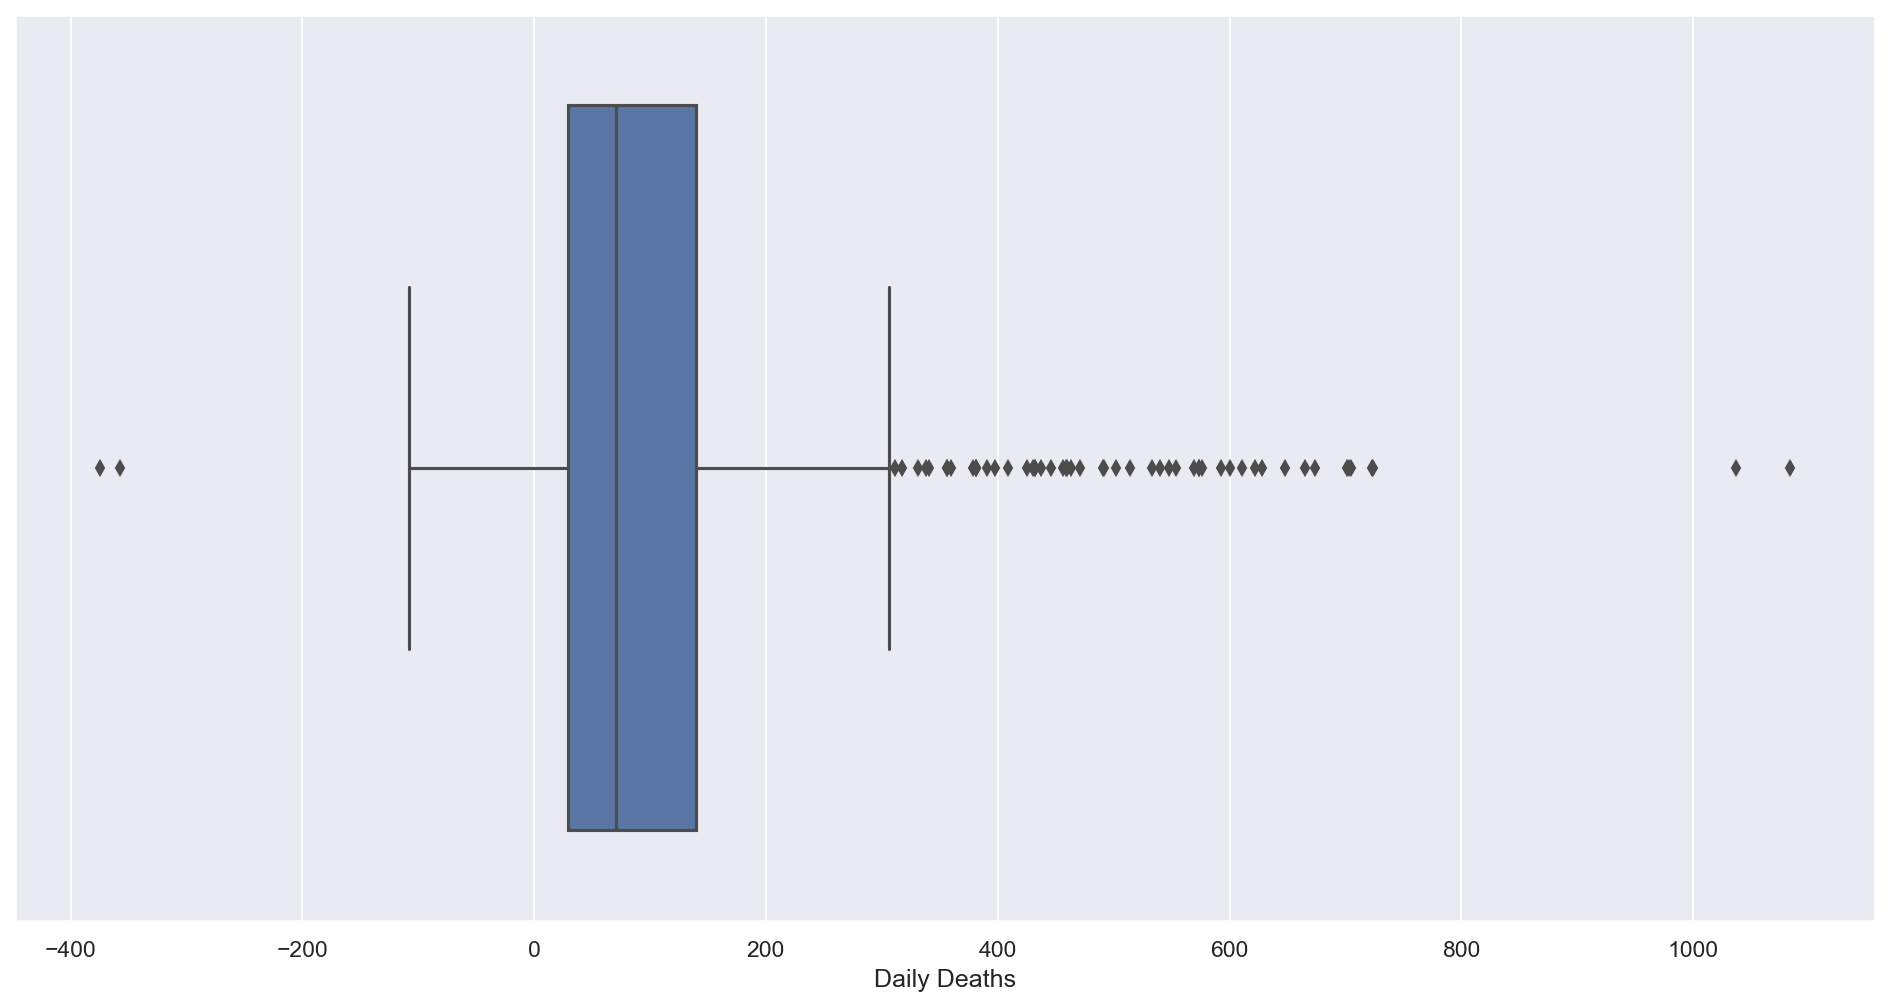

In [322]:
sns.boxplot(caCovidTime['Daily Deaths']);

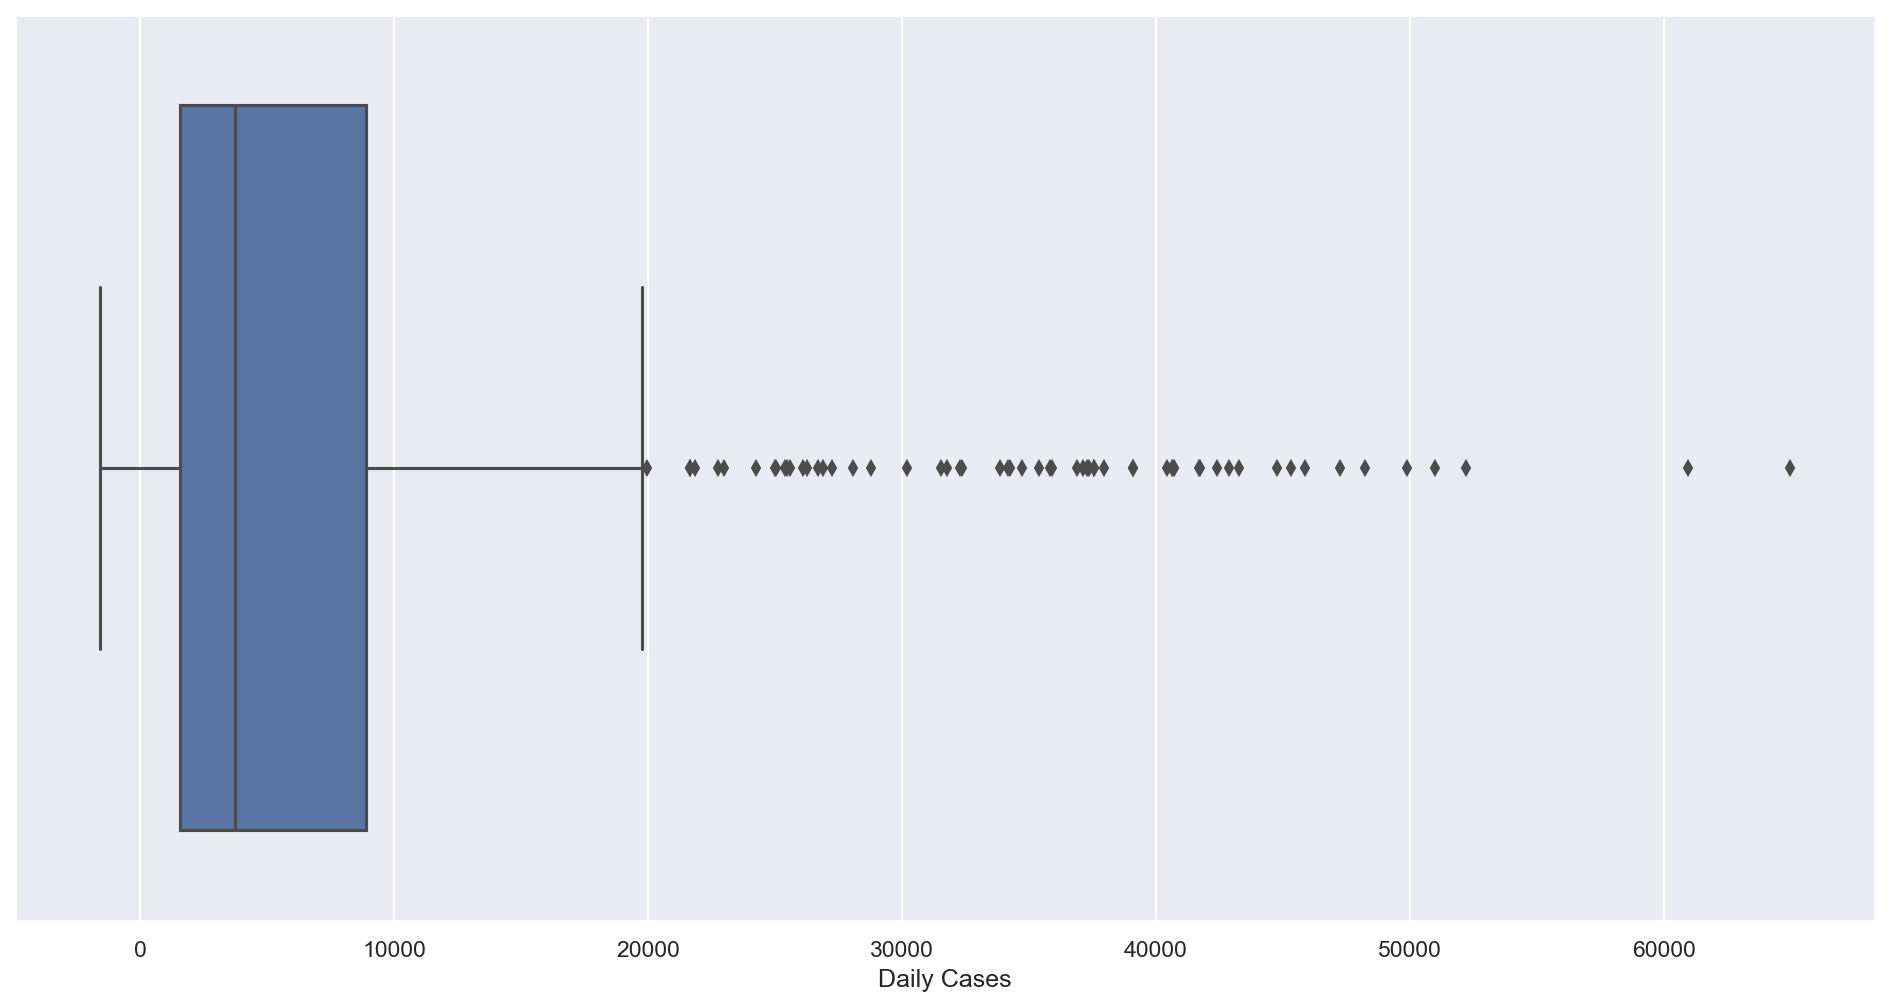

In [323]:
sns.boxplot(caCovidTime['Daily Cases']);

In [324]:
caCovidTime = caCovidTime[(caCovidTime['Daily Deaths'] > 0) & (caCovidTime['Daily Deaths'] < 800)]
caCovidTime = caCovidTime[caCovidTime['Daily Cases'] > 0]

In [325]:
print('Before imputation:')
print(caVaccineTime.isnull().sum())

Before imputation:
date                                    0
location                                0
total_vaccinations                     10
total_distributed                      10
people_vaccinated                      10
people_fully_vaccinated_per_hundred    11
total_vaccinations_per_hundred         10
people_fully_vaccinated                11
people_vaccinated_per_hundred          10
distributed_per_hundred                10
daily_vaccinations_raw                 17
daily_vaccinations                      1
daily_vaccinations_per_million          1
share_doses_used                       10
dtype: int64


Removing the null values from the vaccine data, this is likely due to errors in reporting for some days or the data not being available. 

In [326]:
caVaccineTime.dropna(axis = 0, inplace = True)

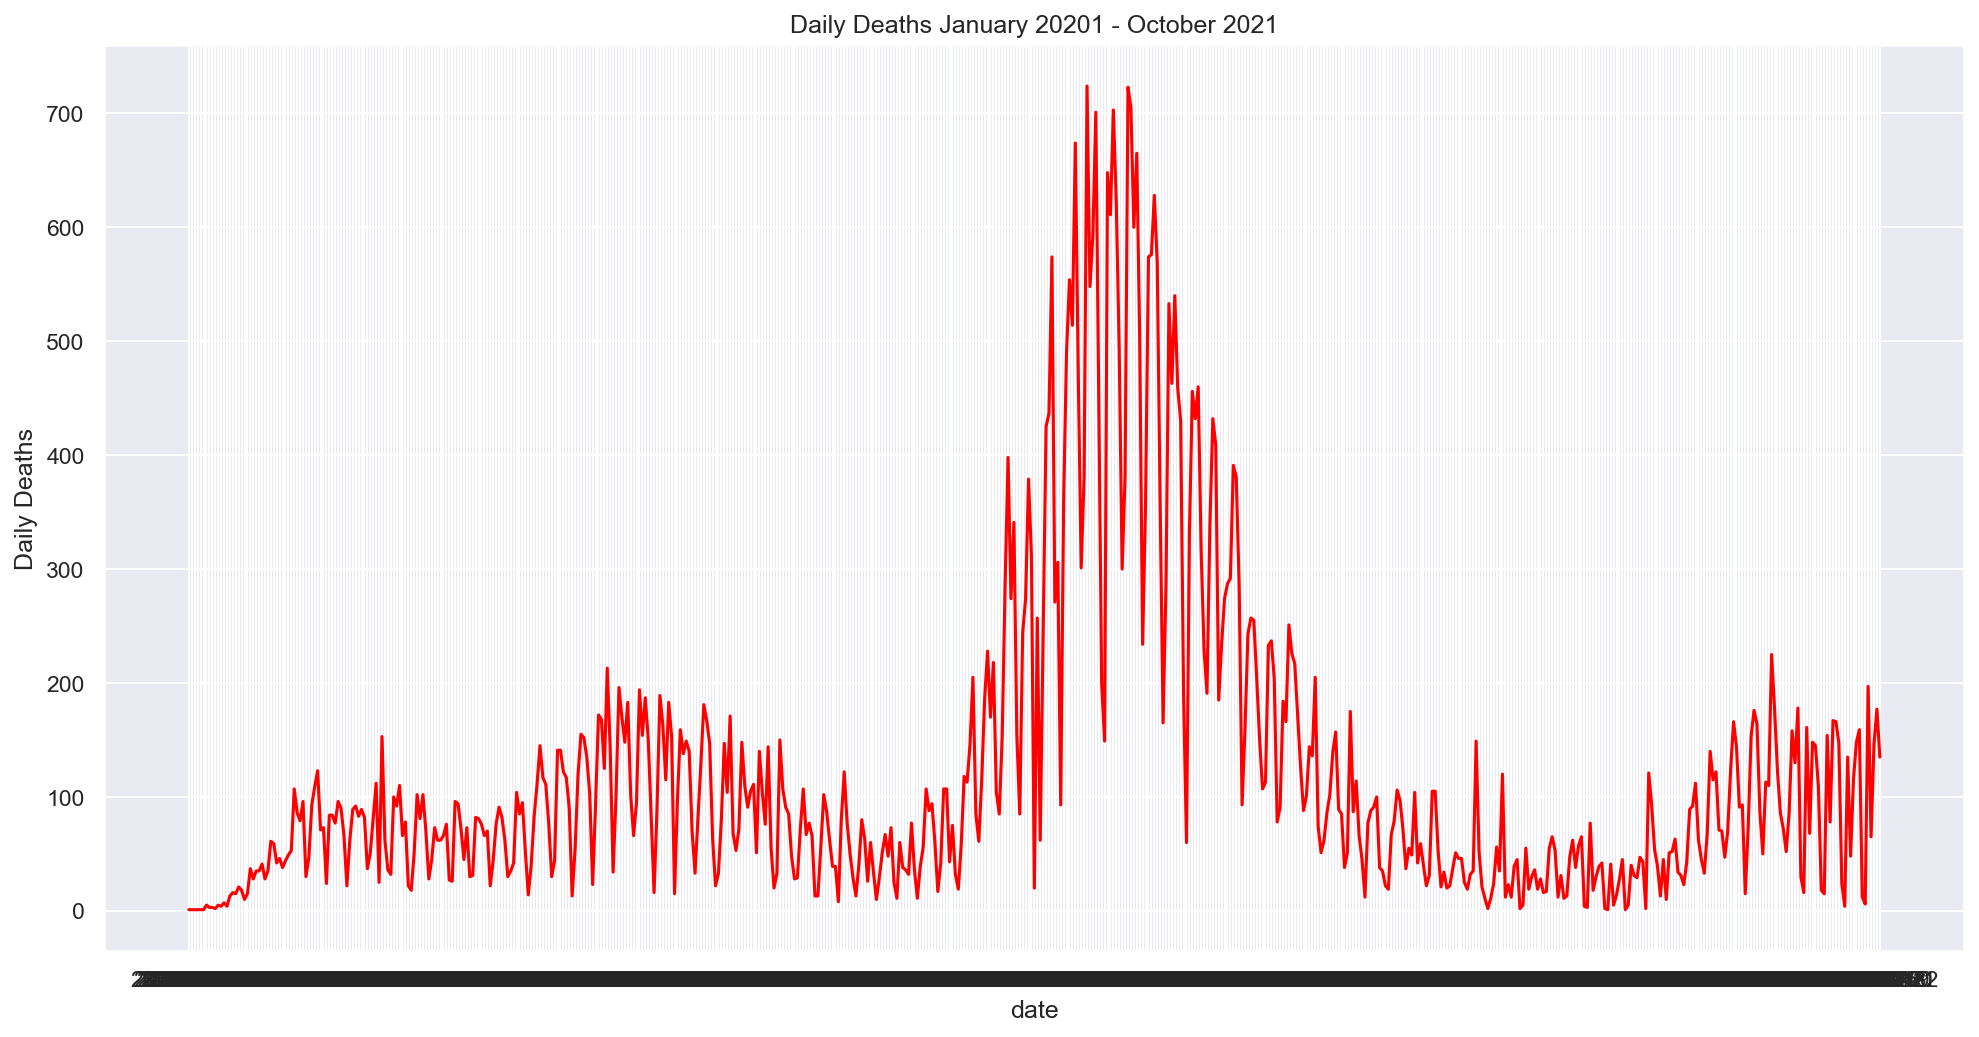

In [327]:
sns.lineplot(x = 'date', y = 'Daily Deaths', data = caCovidTime, color = "red")
plt.title('Daily Deaths January 20201 - October 2021');

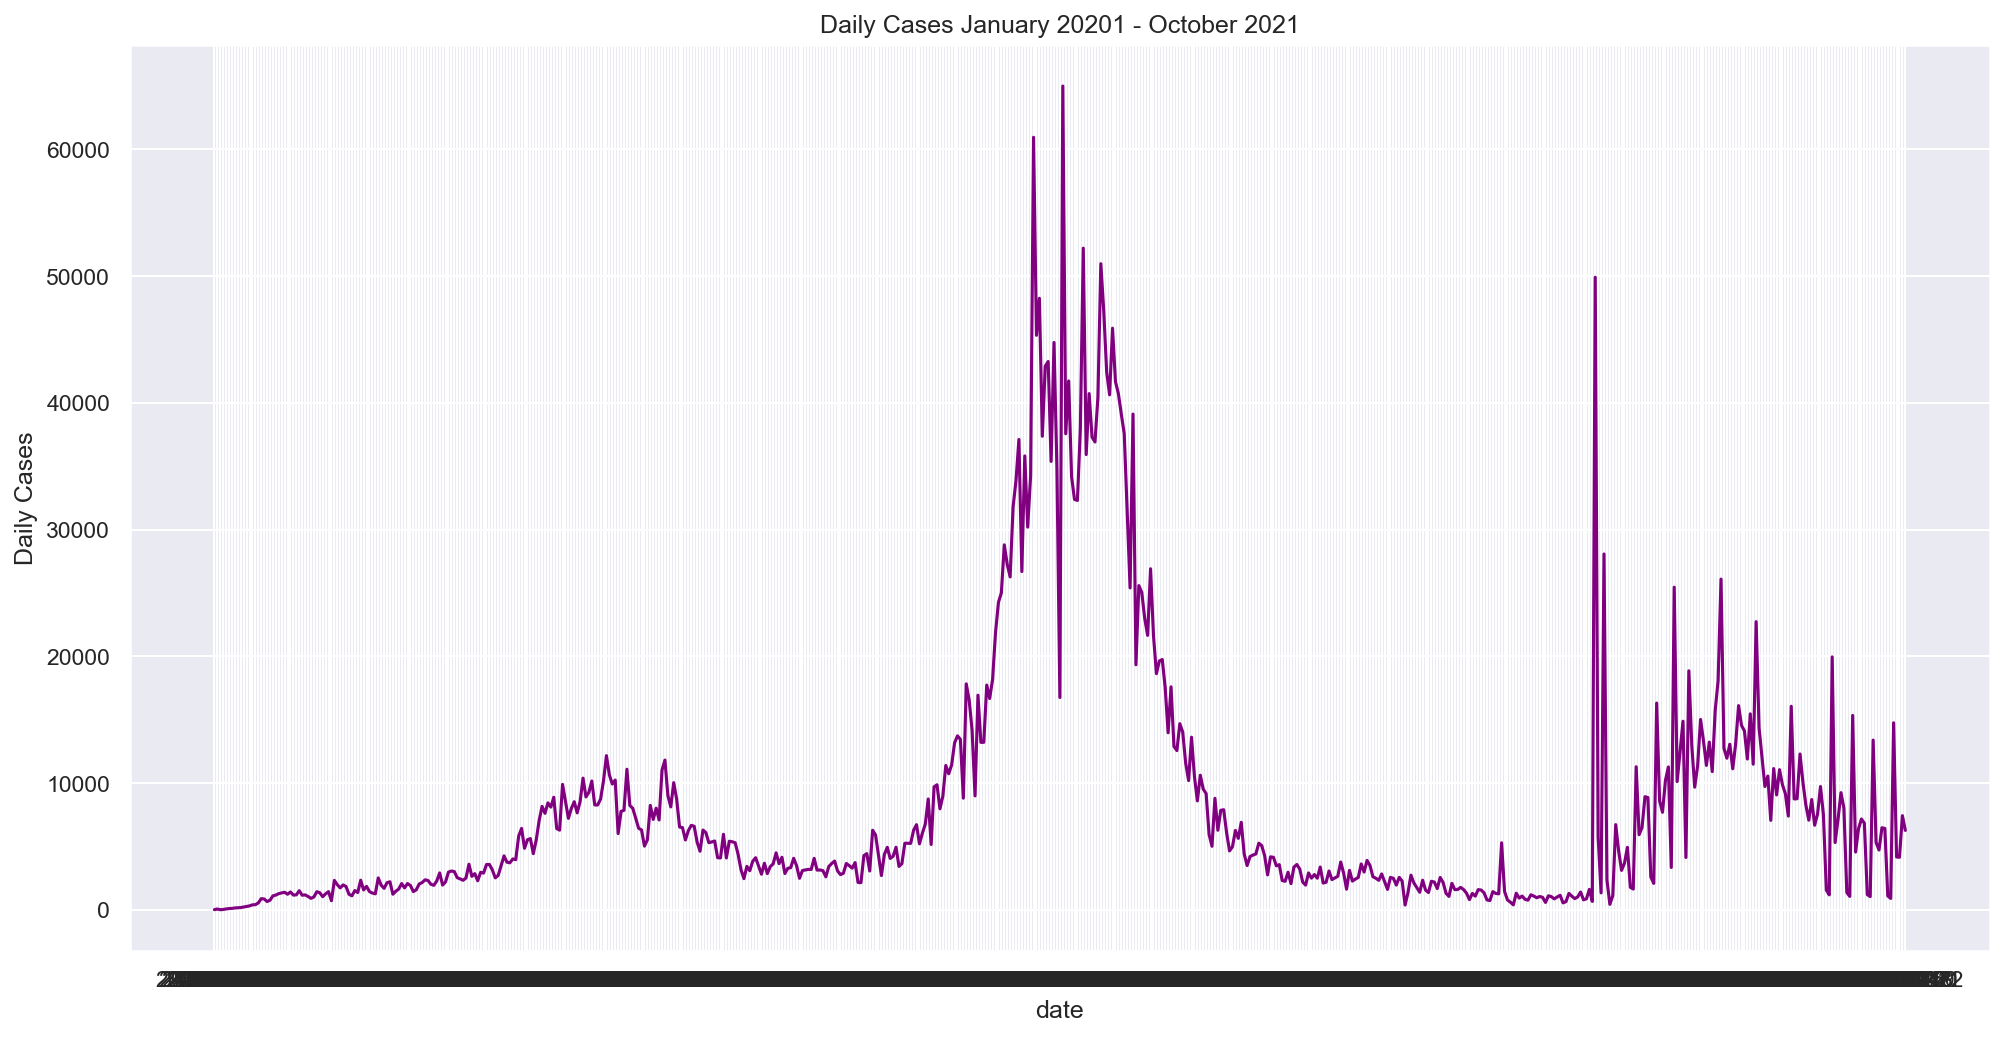

In [328]:
sns.lineplot(x = 'date', y = 'Daily Cases', data = caCovidTime, color = "purple")
plt.title('Daily Cases January 20201 - October 2021');

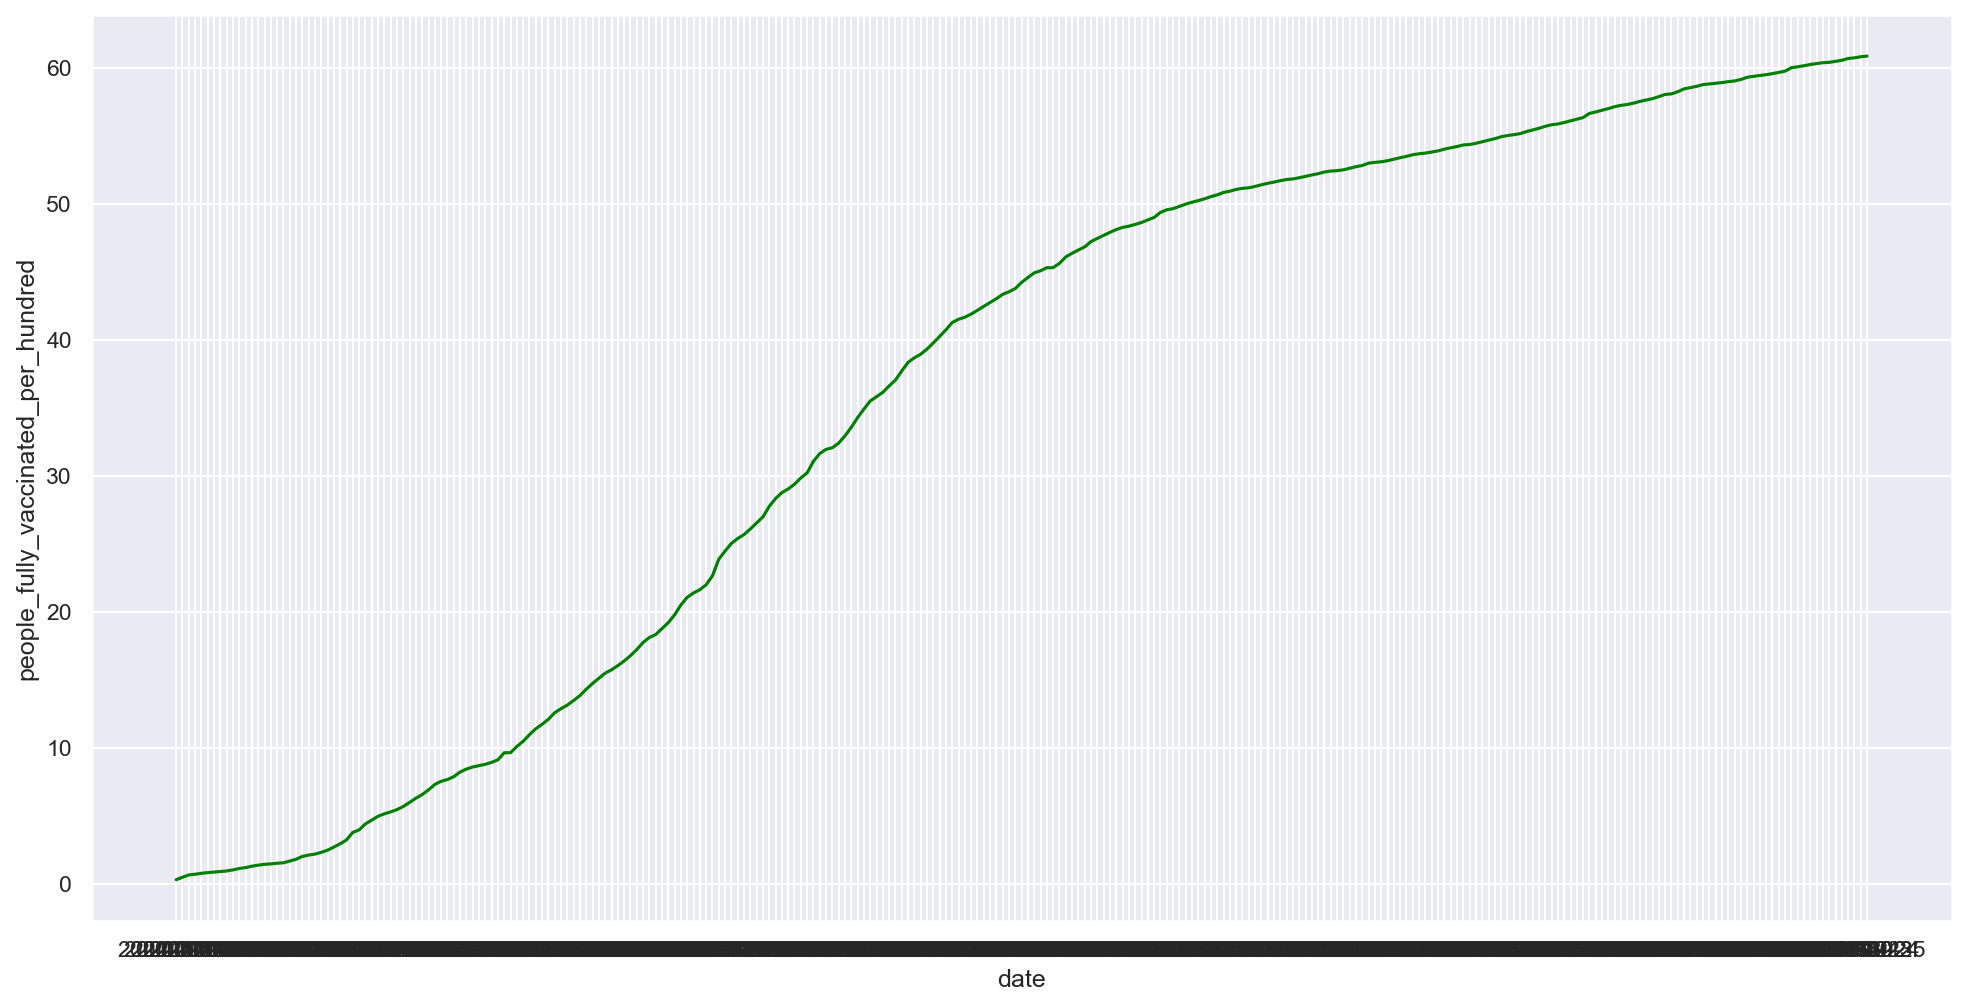

In [329]:
sns.lineplot(x = 'date', y = 'people_fully_vaccinated_per_hundred', data = caVaccineTime, color = 'green');

Observing the following graphs above, we can see that COVID cases and deaths follow a near identical pattern, with the deaths curve having a slight delay over the cases as expected due to a delay between diagnosis and progression of the disease. Overall, we see the vaccine rollout in California increase greatly during the summer months, in which there is a sharp decline in both cases and deaths. As you can see on the curves, as CA approached around 50% fully vaccinated, the number of COVID-19 cases and deaths significantly declined. Although vaccine rates continued to rise (at a slower rate), the cases saw a sharper increase in cases, likely due to the Delta Variant. It is interesting to note that the deaths did not increase as sharply as the cases, likely showing the effect of vaccines on preventing deaths in vaccinated individuals. 

Because most of this general information is widely reported in the news and known to the public, I will now attempt to quantify and further analyze the effect of vaccine distribution on COVID cases and deaths. 

In [330]:
CA_joined = caCovidTime.merge(caVaccineTime, how = 'inner', left_on = 'date', right_on = 'date')

In [331]:
from sklearn.linear_model import LinearRegression
x = CA_joined[['daily_vaccinations']]
y = CA_joined[['Daily Cases']]
model = LinearRegression().fit(x, y)

In [332]:
model.coef_[0][0]

-0.028052896341403503

In [333]:
1/model.coef_[0][0]

-35.64694311168475

In [334]:
model.intercept_[0]

12308.16200674131

Based on simple linear regression model of daily_vaccinations and its effect on daily cases, the daily cases is expected to decrease by .028 cases per individual vaccinated. In other words, for roughly every additional 36 invidividuals that are vaccinated, the daily cases is expected to decrease by 1. The intercept term represents the daily cases when there are no individuals vaccinated in a day; however, this term does not have as much statistical significance as there was almost a year of COVID without vaccines being administered. 

Continuing with a simple regression model, I will use regression to predict the vaccination rate that CA would theoretically need to achieve pre-delta variant case numbers. Instead of using daily vaccinations for this, I will use the percent of the population vaccination (Note: this data set contains data for at least one vaccine per 100 and fully vaccinated per 100; I will use the former for my analysis as one dose has been shown to have a positive effect). This is because the number of vaccinations administered will decrease as more and more of the population is vaccinated. Just to further prove why using daily vaccinations in this model would be incorret: CA would need to increase the daily vaccinations from 100k a day to 400k a day. This is not realistic. 

In [335]:
#Not realistic
model.predict([[400000]])

array([[1087.00347018]])

In [336]:
x = CA_joined[['people_vaccinated_per_hundred']]
y = CA_joined[['Daily Cases']]
model = LinearRegression().fit(x, y)

Every 1% increase in population vaccinated is expected to decrease daily COVID cases by around 48. Currently, around 73% of Californians have received one dose and around 60% have been fully vaccinated. 

In [337]:
model.coef_[0][0]

-48.261897524127995

In [338]:
current = model.predict([[74]])[0][0]

In [339]:
potential = model.predict([[90]])[0][0]

In [340]:
current - potential

772.1903603860474

According to our linear regression model, increasing the vaccination percentage in California to 90% would only decrease daily COVID cases by roughly 800 cases (This would bring down to around 4000, still far away from pre-delta variant numbers which are around 1,000 daily cases). For context, the highest administered vaccine in the USA is Polio with roughly 93% of children receiving this vaccine. MMR and Hepatitis B and Chicken Pox vaccines are all around 90%, but the vast majority of vaccines are admitted to a much lower percentage of the population. This provides a tough task for CA in the fight against COVID-19 as vaccine rates for the COVID vaccine are in fact higher than many common vaccines, including the flu shot. 

Source: CDC

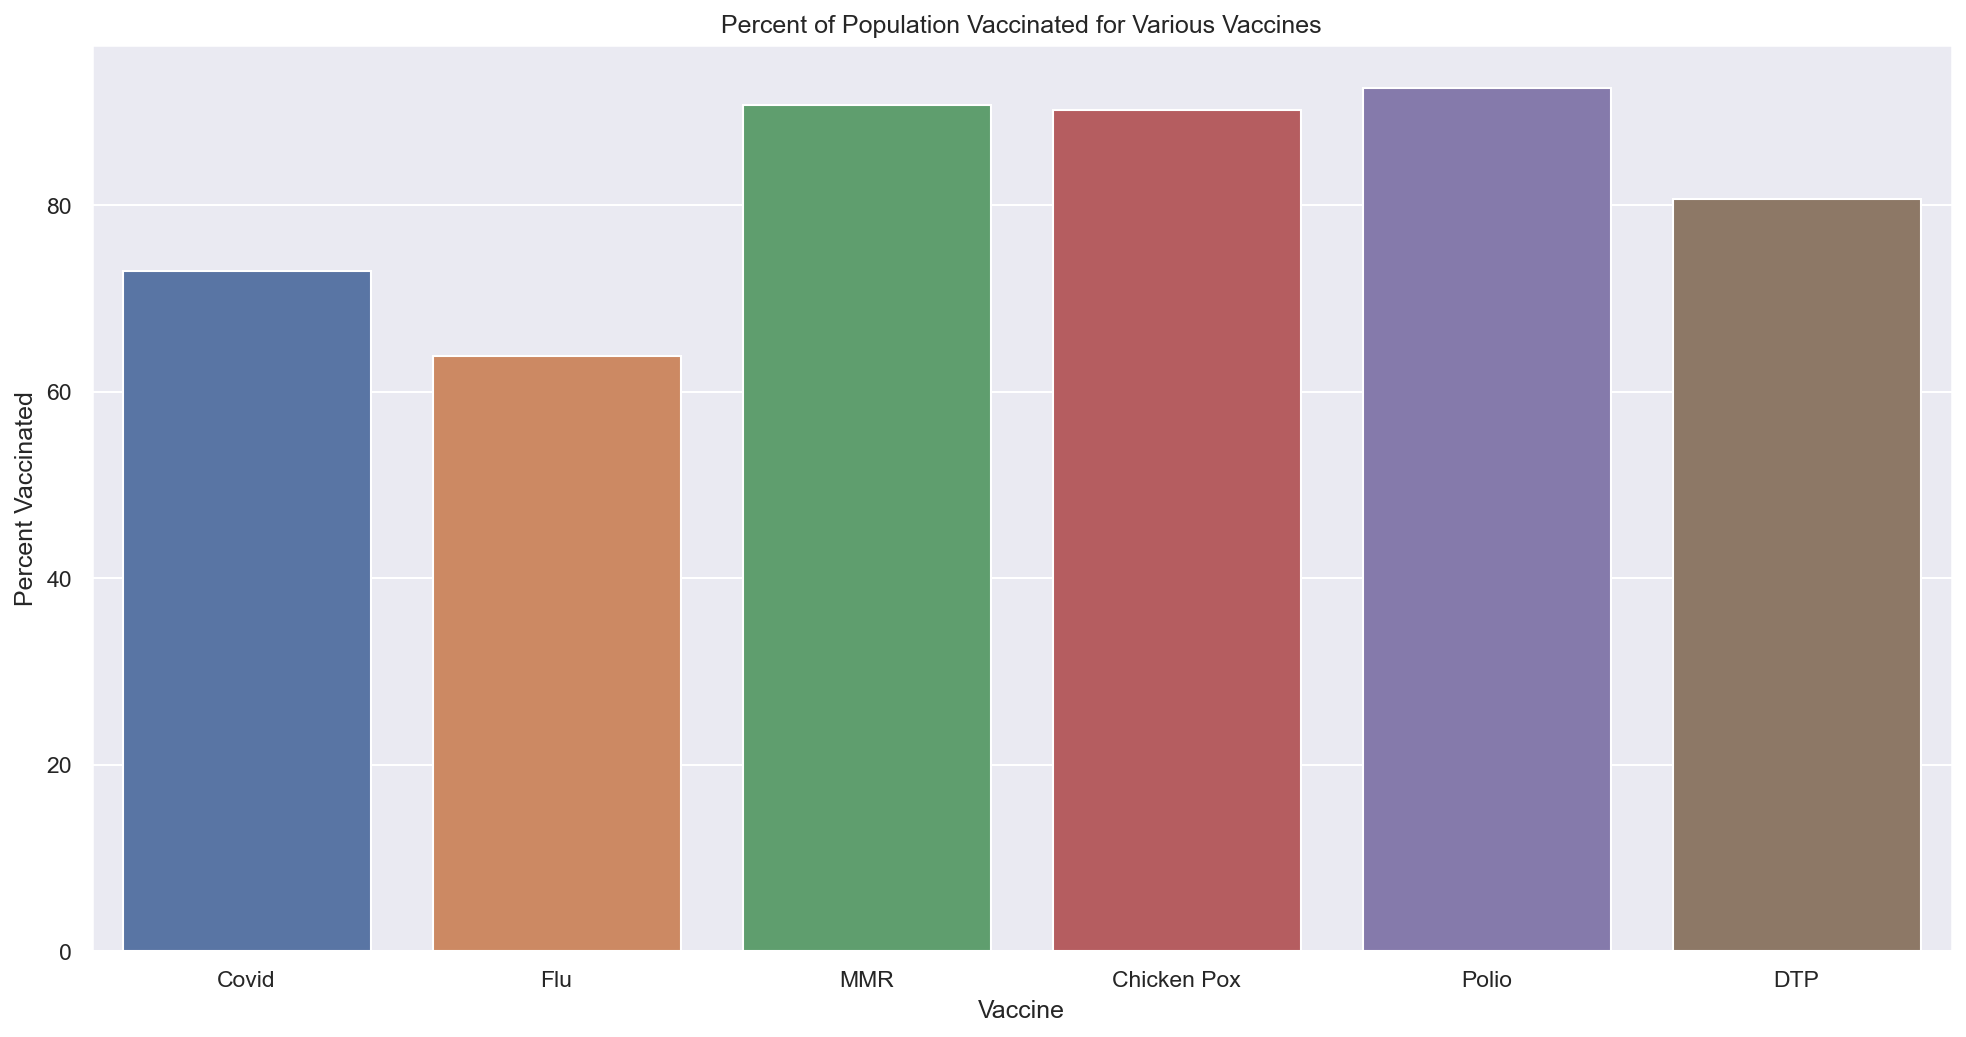

In [341]:
d ={'Vaccine': ['Covid', 'Flu', 'MMR', 'Chicken Pox', 'Polio', 'DTP'], 'Percent Vaccinated': [73, 63.8, 90.8, 90.2, 92.6, 80.7]}
vaccines = pd.DataFrame(data = d)
sns.barplot(x = 'Vaccine', y = 'Percent Vaccinated', data = vaccines)
plt.title('Percent of Population Vaccinated for Various Vaccines');

**Note:** For the MMR, Chicken Pox, Polio, and DTP vaccine, the numbers are for children under 24 months (These vaccines are traditionally given to most newborns and are often required for many schools). Both COVID and Flu vaccines in this graph represent the entire population. 

Now, I will analyxe a multiple regression model and use OLS with L2 regularization to observe the effect on various vaccination factors on daily deaths in California. 

In [342]:
def linear_model(thetas, X):
    return np.dot(X, thetas)
from scipy.optimize import minimize
##OLS
def l2(y, y_hat):
    return (y - y_hat)**2
def minimize_average_loss(loss_function, model, X, y):
    return minimize(lambda theta: np.mean(loss_function(y, model(theta,X))), x0= np.ones(X.shape[1]))['x']

In [343]:
features = CA_joined[['people_vaccinated', 'people_fully_vaccinated_per_hundred', 'people_fully_vaccinated']]
coeffs = minimize_average_loss(l2, linear_model, features, CA_joined['Daily Deaths'])
coeffs

array([ 4.26905825e-05,  3.82078202e+04, -9.67489589e-02])

As seen above, the number of fully vaccinated people had the largest effect on the number of daily deaths. 

## California Further Recommendations

California is already at a high threshold of COVID vaccinations, and historically, the highest vaccine rate is Polio at 92.6%. It is also interesting to note that the Polio vaccine is given to the majority of newborn babies and not adult populations, so it is thus easier to attain a higher rate of vaccination. Given these facts and our analysis above, I will now look at other metrics of our datasets and how they pertain to California. I will analyze whether or not CA is wasting vaccines, as an oversupply can take away critical supply for countries/states in need. 

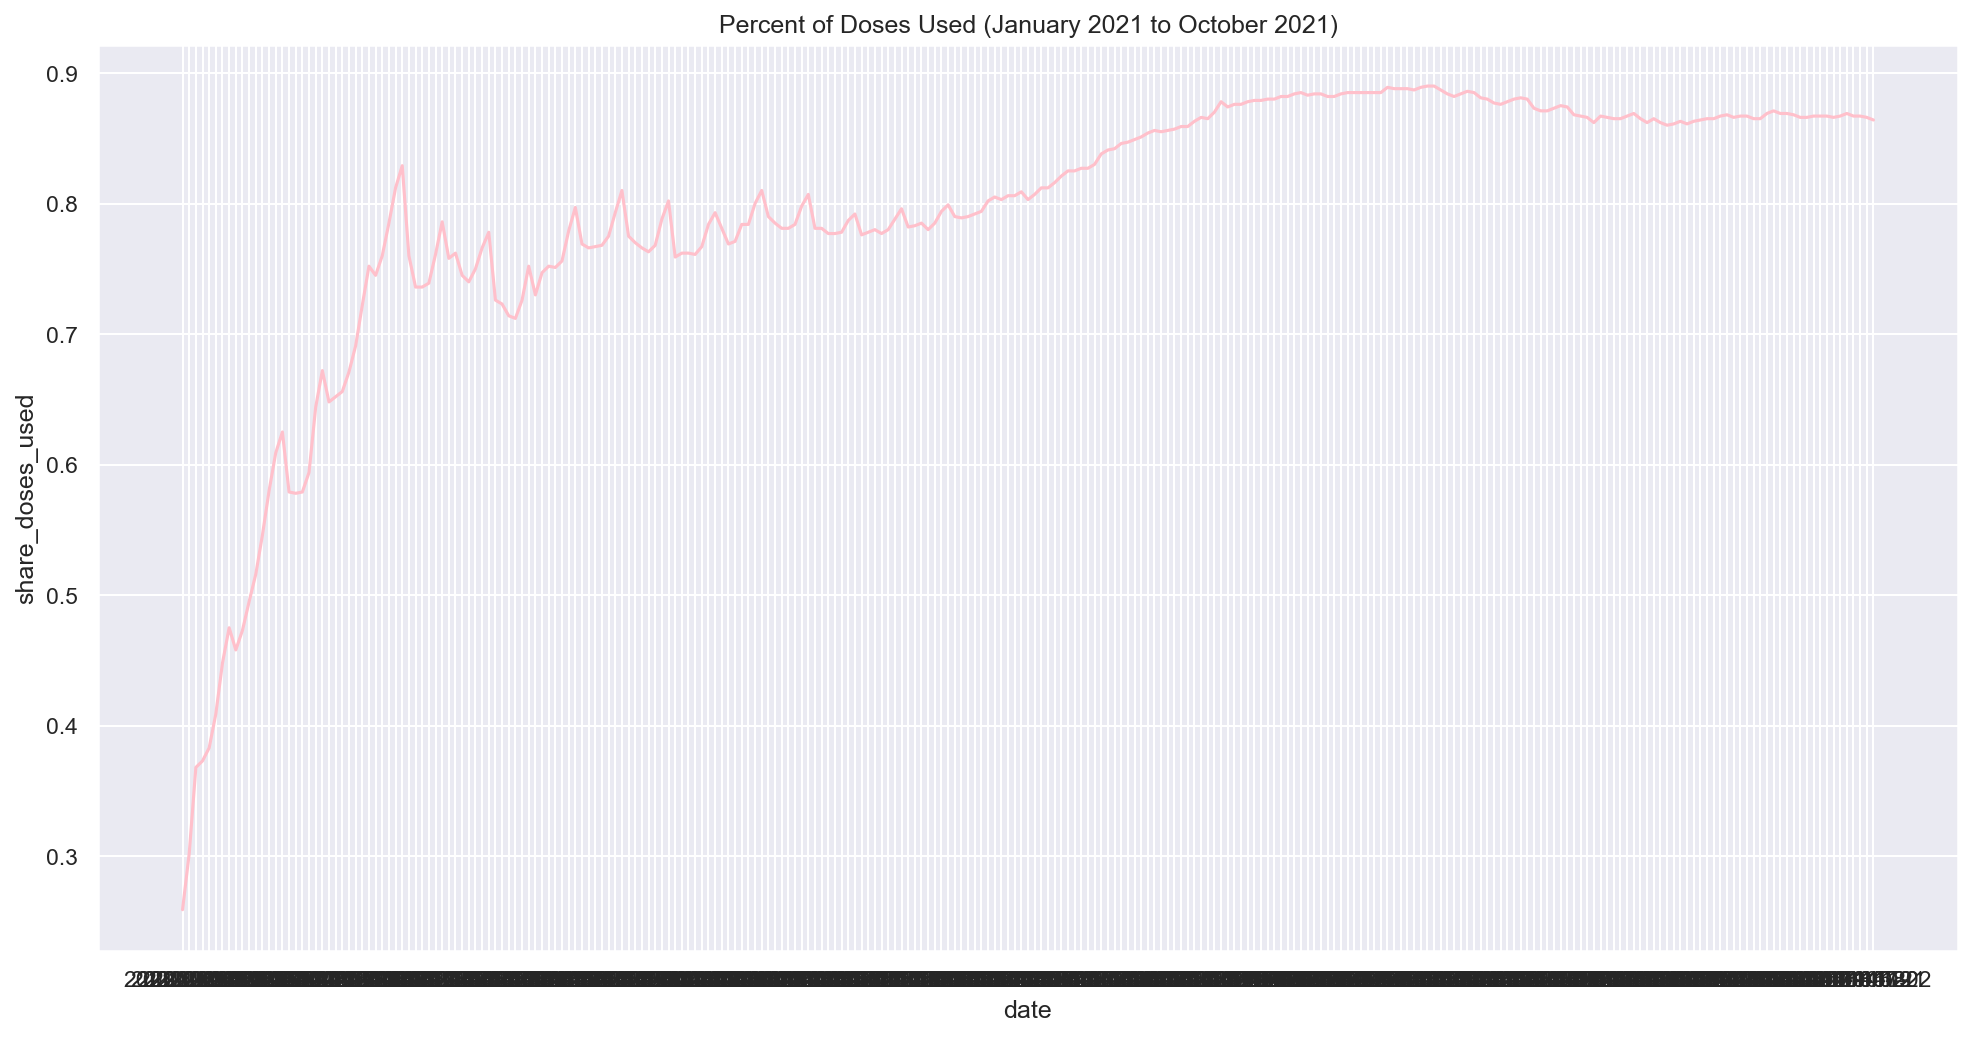

In [346]:
sns.lineplot(x = 'date', y ='share_doses_used', data = CA_joined, color = 'pink')
plt.title('Percent of Doses Used (January 2021 to October 2021)');

Over the course of 2021, California saw a growth in the usage of vaccines as more and more of the population became eligible for a vaccine. Currently, California sits at around 87% of vaccines being distributed to people, thus a low level of waste. Given the recent authorization of booster shots for all 3 vaccines, California will soon need to ramp up its vaccine purchasing to meet demand as more and more patients become eligible. I will now estimate the number of eligible patients for the booster shot (As of 10/22/21, this is the most recent date in the dataset used).

In [360]:
eligible = CA_joined.iloc[90]['people_fully_vaccinated']
print('Total eligible for booster: ' + str(int(eligible)))

Total eligible for booster: 10493528


In [363]:
available = CA_joined.iloc[254]

In [364]:
available['daily_vaccinations']/available['share_doses_used']

114596.06481481482

Based off of the dataset used in my analysis, the current estimated eligible population for a booster shot is around 1.05 million people. Currently based on total vaccines given and share of vaccines used, there is only 115,000 available vaccines today. Thus, California will likely have to ramp up its vaccine distribution as more and more individuals become eligible for a booster shot. With each day, the number of eligible individuals for a booster will increase. Further projects and work could analyze the effect of booster shots on COVID cases and deaths. 

## County Specific Data

In [449]:
county[county['state'] == 'California'].head()

,date,county,state,fips,cases,deaths
5,2020-01-25,Orange,California,6059.0,1,0.0
9,2020-01-26,Los Angeles,California,6037.0,1,0.0
10,2020-01-26,Orange,California,6059.0,1,0.0
14,2020-01-27,Los Angeles,California,6037.0,1,0.0
15,2020-01-27,Orange,California,6059.0,1,0.0


In [393]:
caHesitance = hesitance[hesitance['State'] == 'CALIFORNIA']

In [394]:
hesitanceGeo = gpd.GeoDataFrame(caHesitance[['County Name', 'Percent adults fully vaccinated against COVID-19', 'County Boundary']])
hesitanceGeo.rename(columns={'County Boundary': 'geometry'}, inplace=True)
hesitanceGeo.crs

In [388]:
#fig, ax = plt.subplots(1, 1)
#temp = hesitanceGeo[['Percent adults fully vaccinated against COVID-19','geometry']]
#temp.plot(column = 'Percent adults fully vaccinated against COVID-19', cmap = 'Blues', ax=ax, legend=True);

#, cmap = 'Blues', ax=ax, legend=True

In [405]:
hesitanceGeo['County Name'] = hesitanceGeo['County Name'].str.split(',').str[0]

#### Additional Information on the columns in the hesitance dataset. 

The CDC's Social Vulnerability Index (SVI) summarizes the extent to which a community is socially vulnerable to disaster. The factors considered in developing the SVI include economic data as well as data regarding education, family characteristics, housing language ability, ethnicity, and vehicle access. SVI values range from 0 (least vulnerable) to 1 (most vulnerable). The SVI can also be categorized as follows: Very Low (0.0-0.19), Low (0.20-0.39); Moderate (0.40-0.59); High (0.60-0.79); Very High (0.80-1.0).

The CVAC level of concern is described later in this section. 

Source: CDC

In [443]:
caHesitance.head()

,FIPS Code,County Name,State,Estimated hesitant,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,Percent adults fully vaccinated against COVID-19,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
361,6065,Riverside County,CALIFORNIA,0.12,0.05,0.79,High Concern,0.65,High Concern,0.176,0.4891,0.0043,0.0632,0.0610,0.0027,0.3532,POINT (-119.662127 37.211164),CA,"MULTIPOLYGON (((-117.672439 33.870258, -117.67...","MULTIPOLYGON (((-124.136561 41.464452, -124.15..."
365,6103,Tehama County,CALIFORNIA,0.14,0.05,0.96,Very High Concern,0.83,Very High Concern,0.125,0.2497,0.0139,0.0151,0.0074,0.0002,0.6834,POINT (-119.662127 37.211164),CA,"MULTIPOLYGON (((-122.371476 40.372606, -122.36...","MULTIPOLYGON (((-124.136561 41.464452, -124.15..."
370,6039,Madera County,CALIFORNIA,0.14,0.06,0.95,Very High Concern,0.73,High Concern,0.176,0.5777,0.0099,0.0194,0.0307,0.0009,0.3413,POINT (-119.662127 37.211164),CA,"MULTIPOLYGON (((-120.106385 37.167153, -120.10...","MULTIPOLYGON (((-124.136561 41.464452, -124.15..."
372,6011,Colusa County,CALIFORNIA,0.14,0.05,0.74,High Concern,0.84,Very High Concern,0.167,0.5937,0.0067,0.0127,0.0119,0.0018,0.3531,POINT (-119.662127 37.211164),CA,"MULTIPOLYGON (((-122.080184 39.414203, -122.00...","MULTIPOLYGON (((-124.136561 41.464452, -124.15..."
374,6001,Alameda County,CALIFORNIA,0.09,0.03,0.47,Moderate Concern,0.53,Moderate Concern,0.248,0.2239,0.0031,0.2994,0.1033,0.0080,0.3141,POINT (-119.662127 37.211164),CA,"MULTIPOLYGON (((-122.28088 37.707229999999996,...","MULTIPOLYGON (((-124.136561 41.464452, -124.15..."


In [410]:
caHesitance['County Name'] = caHesitance['County Name'].str.split(',').str[0]

In [417]:
lowVax = caHesitance.sort_values('Percent adults fully vaccinated against COVID-19').iloc[:10]

In analyzing the counties with the 10 lowest vaccination rates and the 10 highest vaccination rates (measured by percent of the adult population vaccinated), minority populations seemed to be a significant difference in the two groups. For example, the percentage of Hispanics in the population is shown for the two different groups. Some counties in the low group had Hispanic populations of 60% with 5/10 of the counties being above 50% Hispanic. In contrast, the high vaccination group had no counties above 35% Hispanic. 

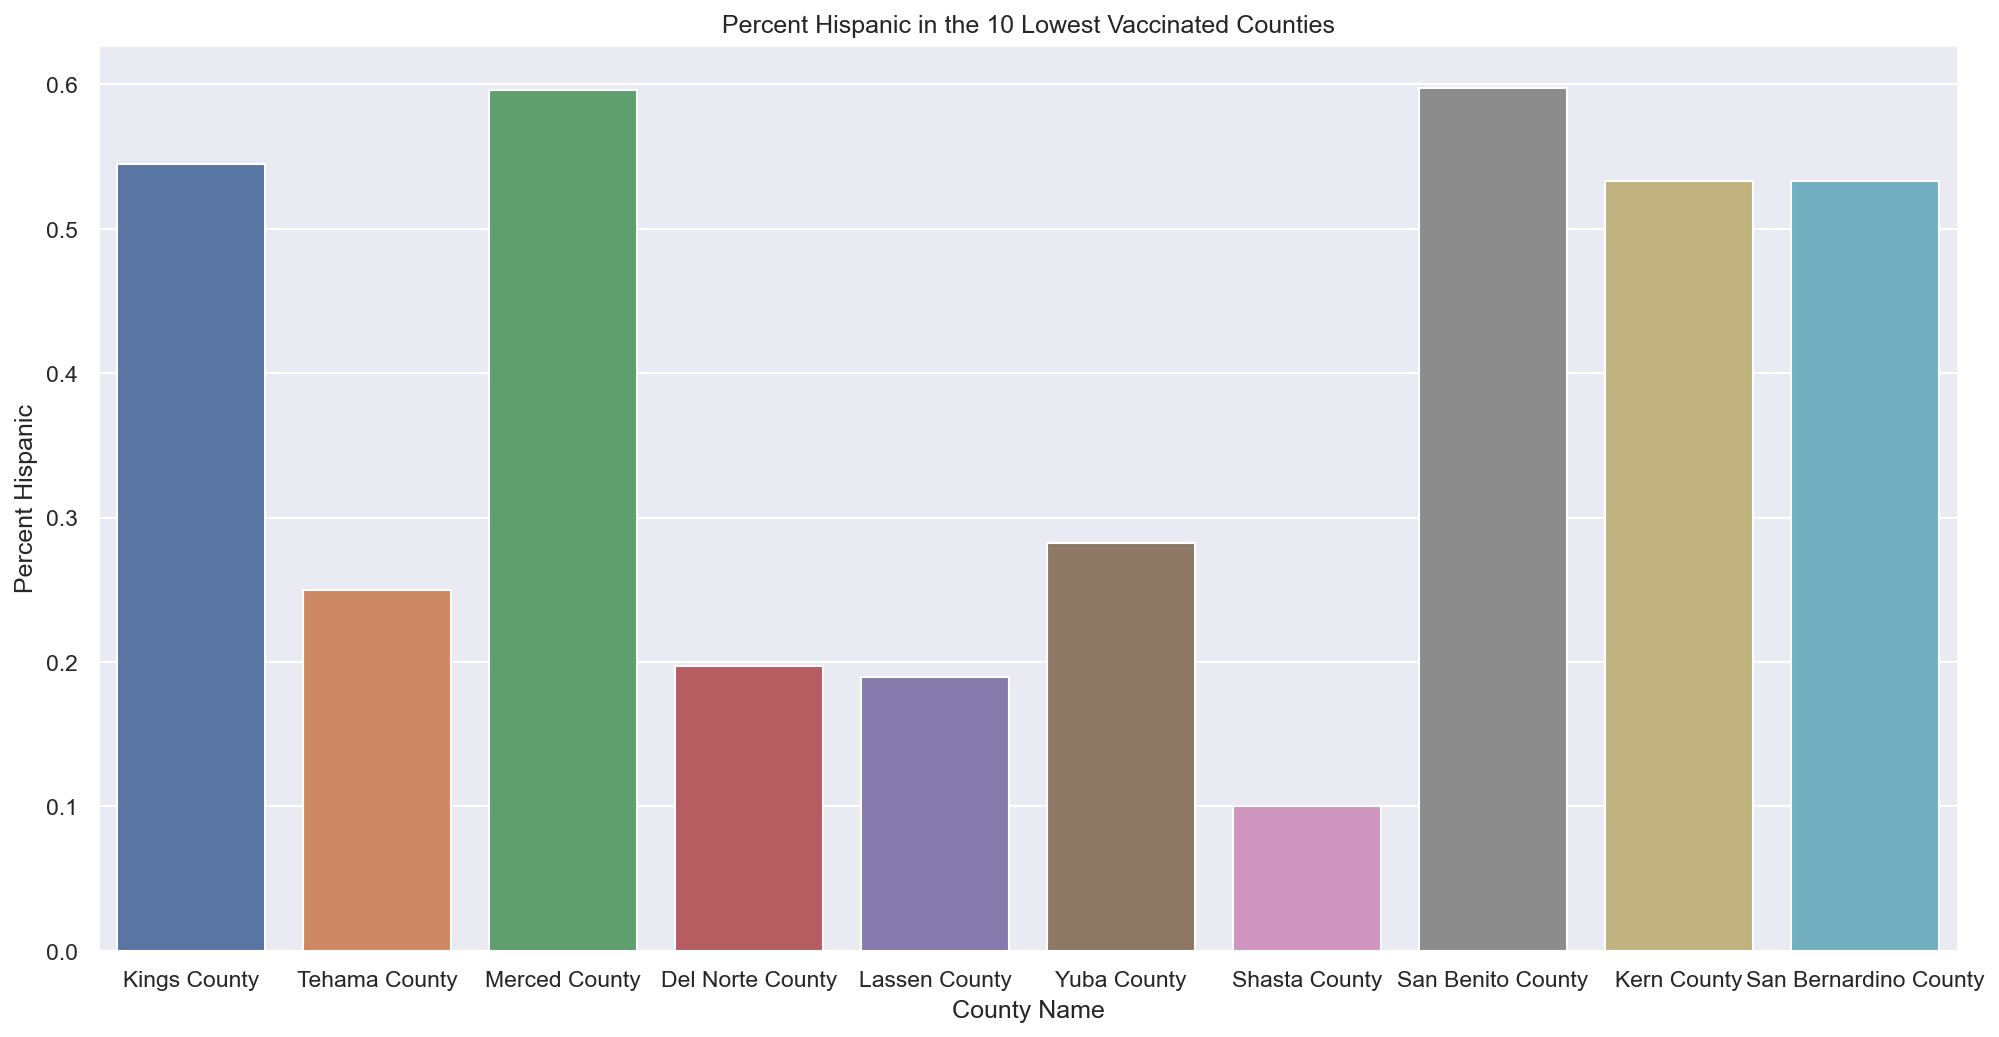

In [420]:
sns.barplot(x = 'County Name', y = 'Percent Hispanic', data = lowVax)
plt.title('Percent Hispanic in the 10 Lowest Vaccinated Counties');

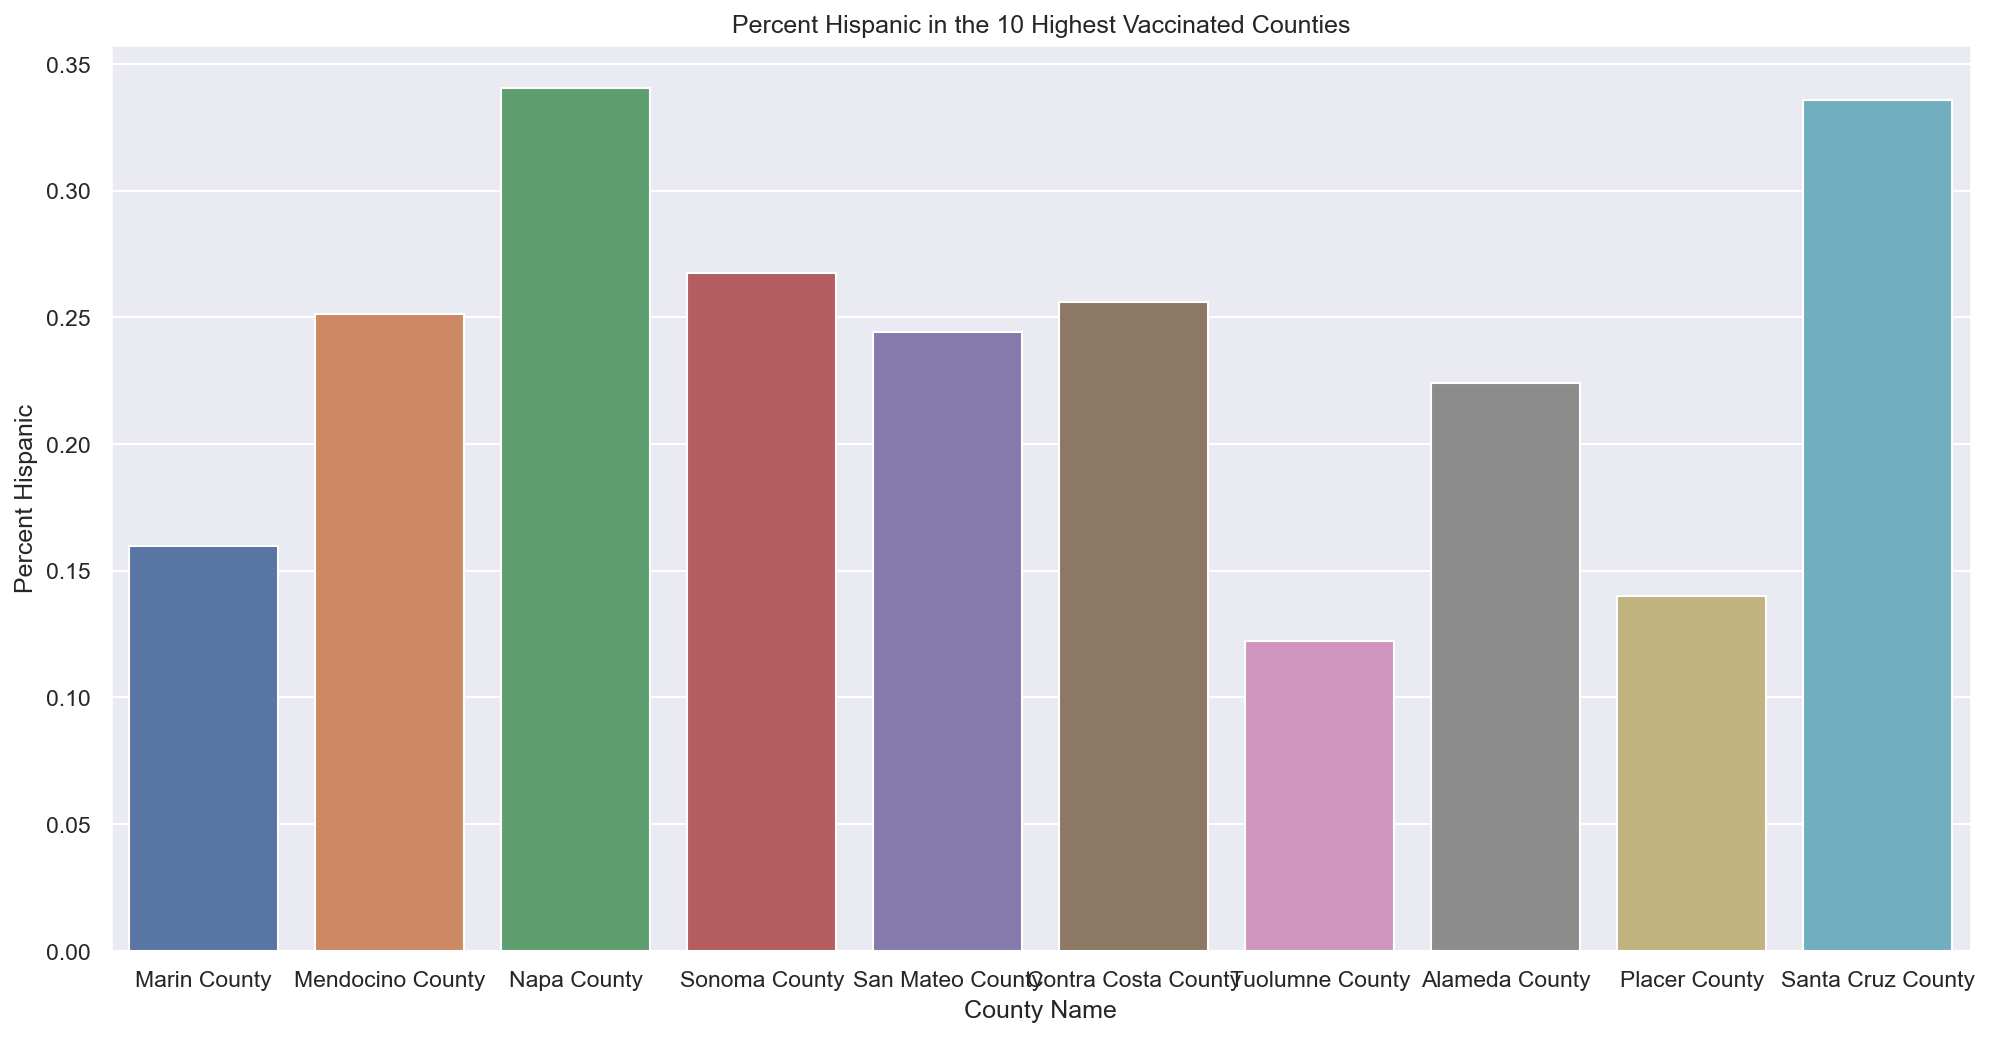

In [421]:
highVax = caHesitance.sort_values('Percent adults fully vaccinated against COVID-19', ascending = False).iloc[:10]
sns.barplot(x = 'County Name', y = 'Percent Hispanic', data = highVax)
plt.title('Percent Hispanic in the 10 Highest Vaccinated Counties');

To further analyze this effect, I will look at the CVAC because it takes in a multitude of factors other than just racial demographics. The Surgo Covid-19 Vaccine Coverage Index (CVAC) captures supply- and demand-related challenges that may hinder rapid, widespread COVID-19 vaccine coverage in U.S. counties, through five specific themes: historic undervaccination, sociodemographic barriers, resource-constrained healthcare system, healthcare accessibility barriers, and irregular care-seeking behaviors. The CVAC measures the level of concern for a difficult rollout on a range from 0 (lowest concern) to 1 (highest concern). The CVAC Index can also be categorized as follows: Very Low (0.0-0.19), Low (0.20-0.39), Moderate (0.40-0.59), High (0.60-0.79), or Very High (0.80-1.0) Concern.

Source: CDC

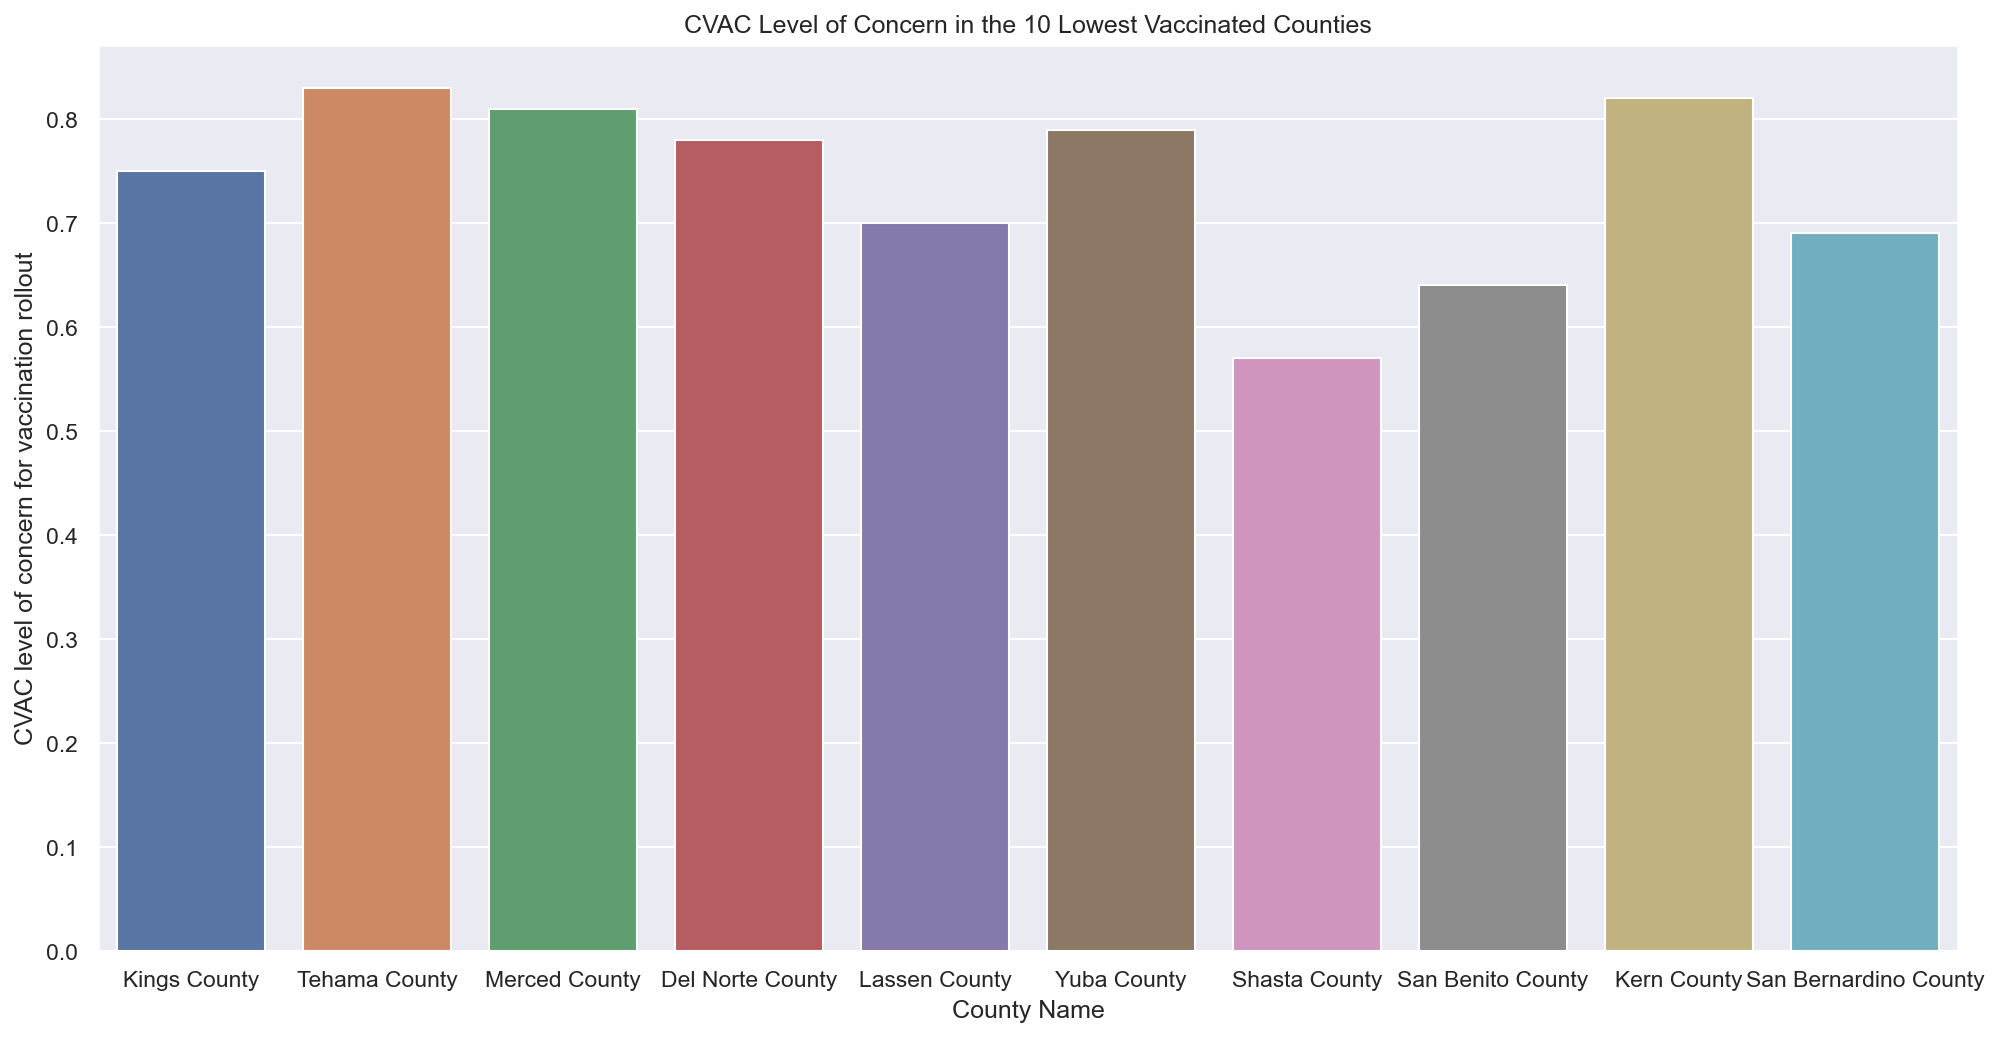

In [425]:
sns.barplot(x = 'County Name', y = 'CVAC level of concern for vaccination rollout', data = lowVax)
plt.title('CVAC Level of Concern in the 10 Lowest Vaccinated Counties');

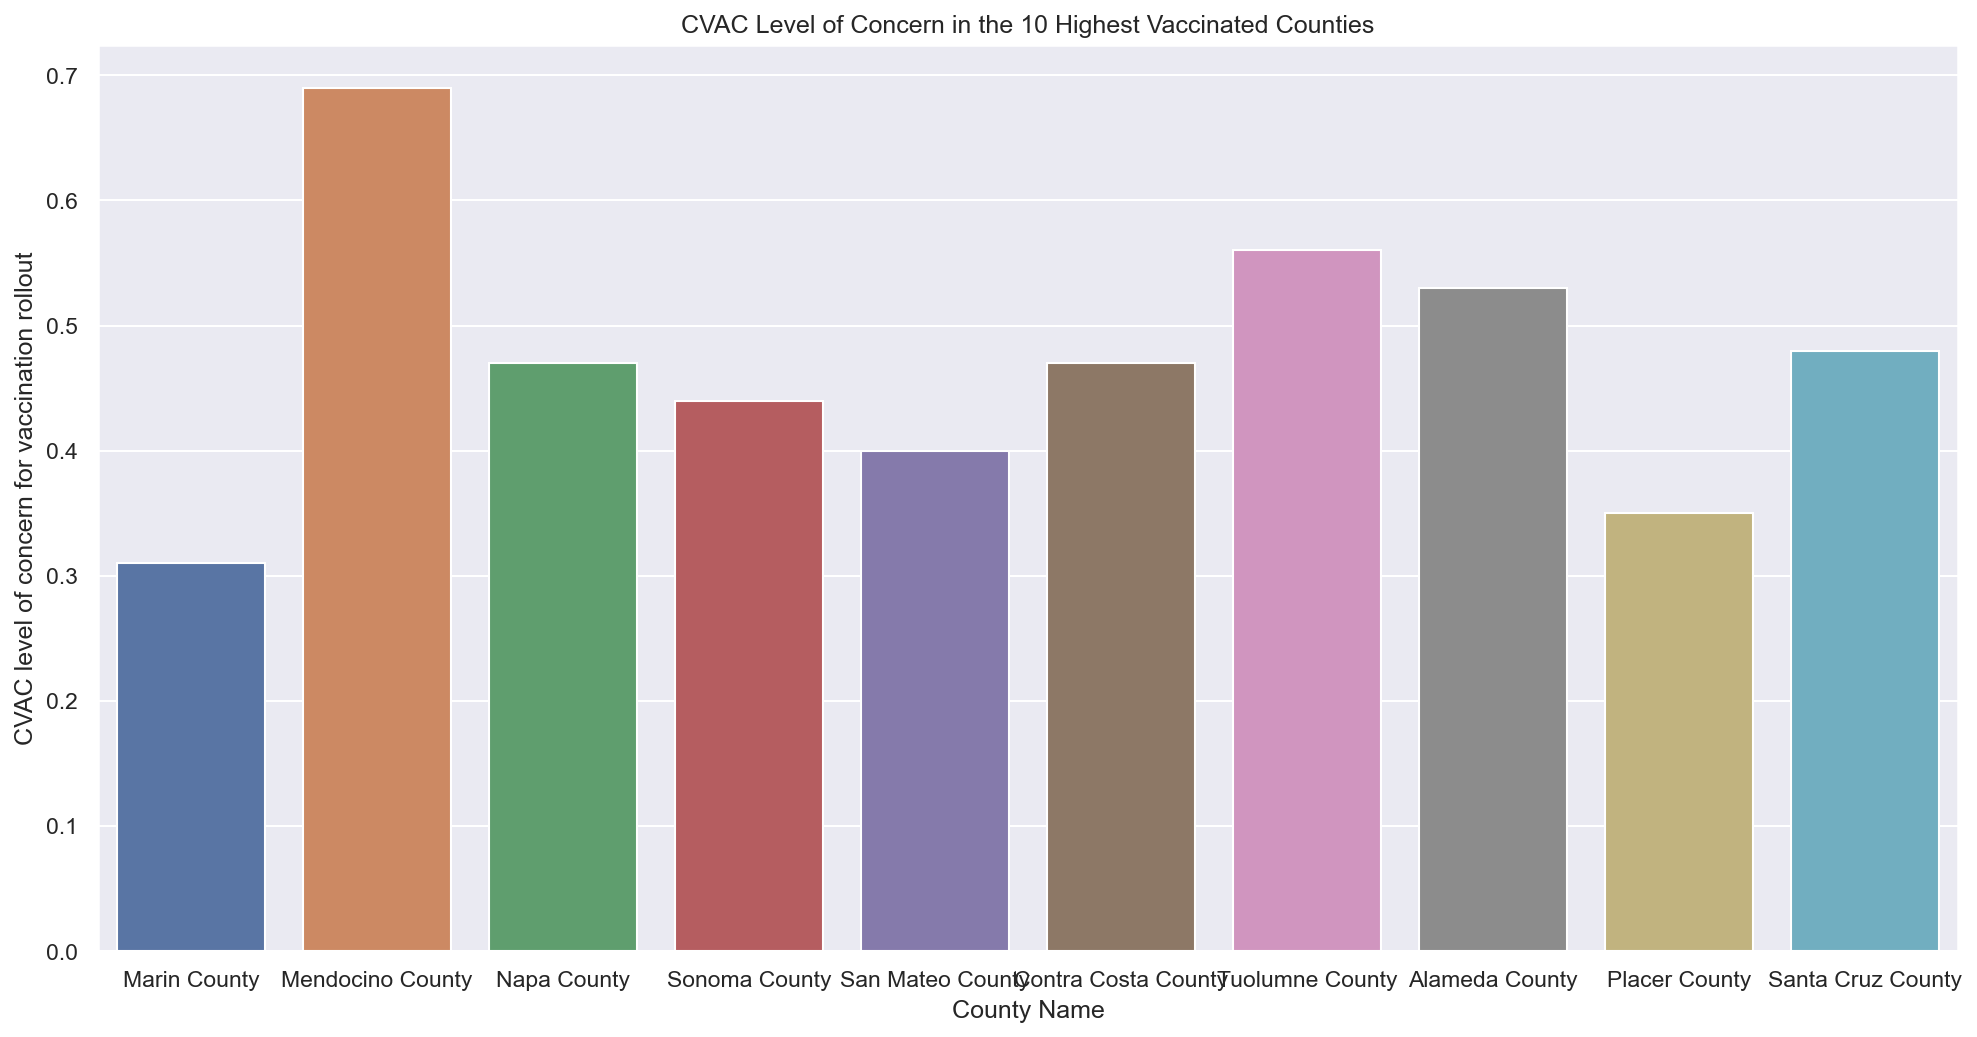

In [424]:
sns.barplot(x = 'County Name', y = 'CVAC level of concern for vaccination rollout', data = highVax)
plt.title('CVAC Level of Concern in the 10 Highest Vaccinated Counties');

Similar to the results of the Hispanic population comparison, the CVAC level of concern is considerably higher in the low vaccination counties. This is one possible explanation for the differences in vaccination levels. To further analyze this, I will conduct a hypothesis test on the mean difference in CVAC in the low and high vaccination counties. 

### Hypothesis Test

H0: The mean CVAC level of concern is equal in high and low vaccination counties. i.e. lowVax mean-highVax mean = 0

H1: The mean CVAC level of concern is greater in low vaccination counties. i.e. lowVax mean-highVax mean > 0

CI = (mu +/- 1.96(SE(X)))

Note: 1.96 is for a 95% confidence interval. 

In [429]:
lowMean = lowVax['CVAC level of concern for vaccination rollout'].mean()
highMean = highVax['CVAC level of concern for vaccination rollout'].mean()
SE = lowVax['CVAC level of concern for vaccination rollout'].sem()

In [436]:
intervalUpperBound = 0 + 1.96 * SE
diff = lowMean - highMean

In [437]:
diff > intervalUpperBound

True

Because the difference in means lies outside of the confidence interval, we can reject the null hypothesis that the mean CVAC level of concern is the same for low vaccination and high vaccination counties. As seen, COVID-19 presents a greater risk to counties that are higher at risk for disaster based on socioeconomic, structural, and various other reasons. This presents a challenge to California. If CA wants to increase its vaccination rollout, it must target these counties that are at greater risk.

In [438]:
lowVax['Estimated hesitant'].mean()

0.14100000000000001

In [439]:
highVax['Estimated hesitant'].mean()

0.09999999999999999

In [440]:
lowVax['Estimated strongly hesitant'].mean()

0.05600000000000001

In [441]:
highVax['Estimated strongly hesitant'].mean()

0.04

In addition to risk levels, the lower vaccinated counties also have an increased hesitance to receiving the vaccine. This may be due to educational reasons, religious beliefs, or political ideologies -- this could be studied in future studies. Regardless of the reasoning, there is a further challenge for California in combatting COVID as these counties are at high risk and they are reluctant to actually receiving the vaccine; thus, increased supply to these areas may not be the solution to increasing a vaccination threshold and decreasing COVID cases. 